# Preventing Leakage by identify origination columns

## Summary
Kudos to [Tyson](!https://www.kaggle.com/tysonpo), whom with his [notebook](!https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook) gave a good idea/proposal of columns that were by the moment of credit's origination.

He compare the dataset given with a newer snapshot of columns and status of loans and his criteria is that the columns that did change would be columns calculated after the origination, during the credit life, hence would cause leakage if those were use as features of models.

At the same time, the columns didn't change are the first proposal of columns that were during origination. Nevertheless, he warnings that the absent of change in some columns could be becasuse Lending Club didn't update the data and that would mean, those columns were not at origination. 

Another important thing is that, even when a column didn't change and it's assumed that were at origination, it doesn't mean that column was prior to the risk evaluation ste. For example, if the approved amount happens after the risk evaluation, the `loan_amnt` would carry some leakage and it make sense for that column according with the dictionary of the dataset:

```
loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
```

So, since I don't know very well the steps in the flow of the evaluation used by Lending Club, I need to work under some asumptions overhere, such as:

- The columns that [Tyson's process](!https://www.kaggle.com/tysonpo) identify with change between snapshots samples, would be considered with leakage and remove from possible model's features set

- The columns without change would be considered as potential model's features. I would zoom into them and try to remove the ones I think they carry some leakage, such as the `loan_amnt` column.

- These would mean I will be removing some false-leakage features and adding some false-no-leakage features to the train dataset, as consecuence of my lack of knowlage and understanding of the evaluation flow and the correct interpretation of the dataset dictionary.

## [Tyson's process](!https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from typing import Any

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)        # Sin límite de ancho
pd.set_option('display.max_colwidth', 50)   # Ancho máximo de columna


# load new data and convert dates
df_new = pd.read_csv("../data/Loan_status_2007-2020Q3.csv")
df_new["issue_d"] = pd.to_datetime(df_new["issue_d"], format="%b-%Y")
df_new["last_pymnt_d"] = pd.to_datetime(df_new["last_pymnt_d"], format="%b-%Y")
df_new.shape # one of the 142 columns is "Unnamed 0" -- the result of using pd.to_csv without specifying index=False


# 2017-04-01 is the last payment day in the old data
# any loans that completed before 2017-04-01 were up to date as of the old data
# thus we will remove these loans
df_new = df_new.loc[df_new["last_pymnt_d"] > datetime(2017,4,1)] 
print(df_new.shape)
df_new00 = df_new.copy()

# load old data and convert dates
df_old = pd.read_csv("../data/accepted_2007_to_2018Q4.csv")
df_old["issue_d"] = pd.to_datetime(df_old["issue_d"], format="%b-%Y")
df_old["last_pymnt_d"] = pd.to_datetime(df_old["last_pymnt_d"], format="%b-%Y")
df_old00 = df_old.copy()





missing_cols = [x for x in df_old00.columns if x not in df_new00.columns]
print(df_old.shape)


ids = df_new["id"].sample(n=10000, random_state=123).values
df_new = df_new.loc[df_new["id"].isin(ids)]
df_old = df_old.loc[df_old["id"].isin(ids)]
df_new = df_new.loc[df_new["id"].isin(df_old["id"].values)] # df_new may have too many rows now, so we filter again
print(df_new.shape, df_old.shape)


df_new = df_new.sort_values("id")
df_old = df_old.sort_values("id")

# confirming alignment
print(np.mean(df_new["id"].values == df_old["id"].values)) # should be 100%

# aligning columns
common_cols = [x for x in df_new.columns if x in df_old.columns]

# which columns aren't in common?
print("Columns in new data not in old:", set(df_new.columns).difference(set(df_old.columns)))
print("Columns in old data not in old:", set(df_old.columns).difference(set(df_new.columns)))


df_new = df_new[common_cols]
df_old = df_old[common_cols]
print(df_new.shape, df_old.shape)

# confirming alignment
print(np.mean(df_new.columns == df_old.columns)) # should be 100%


# reformatting new data to match old data
df_new["revol_util"] = df_new["revol_util"].apply(lambda x: x.strip().replace("%","") if type(x) == str else np.nan).astype('float64')
df_new["int_rate"] = df_new["int_rate"].apply(lambda x: x.strip().replace("%","") if type(x) == str else np.nan).astype('float64')


# identifying non-matching (I refer to these as 'uncommon') instances
uncommon = []
for i in range(len(df_new)):
    x = df_new.iloc[i,:].fillna("NULL")
    y = df_old.iloc[i,:].fillna("NULL")
    uncommon_xy = df_new.columns[x.values != y.values].values
    uncommon.extend(uncommon_xy)
#     print(uncommon_xy)
#     display(df_new[uncommon_xy].values[i])
#     display(df_old[uncommon_xy].values[i])

/var/folders/kl/z4y0w58x06v4841j8095kd0c0000gq/T/ipykernel_57179/547696827.py:13: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv("../data/Loan_status_2007-2020Q3.csv")


(2304226, 142)


/var/folders/kl/z4y0w58x06v4841j8095kd0c0000gq/T/ipykernel_57179/547696827.py:27: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_old = pd.read_csv("../data/accepted_2007_to_2018Q4.csv")


(2260701, 151)
(6872, 142) (6872, 151)
1.0
Columns in new data not in old: {'Unnamed: 0'}
Columns in old data not in old: {'debt_settlement_flag_date', 'disbursement_method', 'settlement_date', 'settlement_amount', 'member_id', 'sec_app_mths_since_last_major_derog', 'desc', 'settlement_percentage', 'settlement_term', 'settlement_status'}
(6872, 141) (6872, 141)
1.0


In [2]:
from typing import Any
counter_dict = Counter[Any](uncommon)
counter_dict.keys()

dict_keys(['last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'total_pymnt', 'total_pymnt_inv', 'recoveries', 'collection_recovery_fee', 'loan_status', 'out_prncp', 'out_prncp_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'total_rec_late_fee', 'hardship_flag', 'hardship_amount', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'int_rate', 'installment', 'pymnt_plan'])

In [3]:
[x for x in df_old.columns if x in counter_dict.keys() and 'pub' in x]

[]

# Analyzing each column from dataset and dictionary

## Only from intersection between old and new datasets

- The potential feature columns are the ones are not at the `counter_dict`.
    - The `counter_dict` contains the columns that did change their values between two snapshots of time for some loans, and our (*Tyson's*) assumption is that means those columns contain information about the loan's life such as payments, status, etc... hence that information wasn't available at the loan's origination.

In [4]:
potencial_orig_cols = [x for x in df_old.columns if x not in counter_dict.keys()]
df_old[potencial_orig_cols].dtypes.to_frame("type").reset_index().groupby(['type']).count()

,index
type,
float64,87
datetime64[ns],1
object,18


In [5]:
display(
    df_old[[x for x in df_old.columns
    if x not in counter_dict.keys() and df_old.dtypes[x]=='datetime64[ns]']]
    )

,issue_d
1918091,2012-07-01
1917840,2012-07-01
1898969,2012-10-01
1799035,2013-09-01
1896164,2012-11-01
...,...
1358761,2018-12-01
1356002,2018-12-01
1357525,2018-12-01
1357111,2018-12-01


In [6]:
display(
    df_old[[x for x in df_old.columns
    if x not in counter_dict.keys() and df_old.dtypes[x]=='object']]
    )

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type,verification_status_joint,sec_app_earliest_cr_line
1918091,1401548,60 months,C,C2,Radlo Foods,10+ years,MORTGAGE,Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,CC Consolidate,029xx,RI,May-1989,f,Individual,NaN,NaN
1917840,1404973,60 months,E,E2,NaN,7 years,MORTGAGE,Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,business,179xx,PA,Mar-1998,f,Individual,NaN,NaN
1898969,1523187,60 months,C,C5,GE,10+ years,MORTGAGE,Source Verified,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Basement Finish Remodel,450xx,OH,Apr-1986,w,Individual,NaN,NaN
1799035,1543032,60 months,B,B3,Community eye care,5 years,RENT,Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Personal,104xx,NY,Feb-2005,w,Individual,NaN,NaN
1896164,1626236,60 months,D,D5,The Vigue Company,7 years,RENT,Verified,https://lendingclub.com/browse/loanDetail.acti...,other,Other,974xx,OR,Feb-2003,f,Individual,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358761,145455202,36 months,A,A4,Teacher,6 years,OWN,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,117xx,NY,Sep-2007,w,Individual,NaN,NaN
1356002,145456097,36 months,C,C1,Systems Engineer,10+ years,RENT,Verified,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,070xx,NJ,Jun-1998,w,Individual,NaN,NaN
1357525,145468605,60 months,B,B4,driver,5 years,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,604xx,IL,Nov-1996,w,Individual,NaN,NaN
1357111,145490927,36 months,D,D3,Account executive,9 years,MORTGAGE,Verified,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,218xx,MD,Jul-1999,w,Individual,NaN,NaN


In [7]:
display(
    df_old[[x for x in df_old.columns
    if x not in counter_dict.keys() and df_old.dtypes[x]=='float64']]
    )

,loan_amnt,funded_amnt,funded_amnt_inv,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med
1918091,17000.0,17000.0,17000.0,61000.0,17.34,0.0,710.0,714.0,0.0,NaN,NaN,9.0,0.0,23763.0,80.8,30.0,0.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2701.0,89.3,0.0,0.0,NaN,NaN,NaN,NaN,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,NaN,33351.0,25200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917840,23375.0,23375.0,23375.0,60000.0,26.46,0.0,675.0,679.0,0.0,NaN,NaN,8.0,0.0,23366.0,66.2,20.0,0.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,590.0,96.8,0.0,0.0,NaN,NaN,NaN,NaN,0.0,5.0,NaN,7.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,NaN,55923.0,18300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1898969,20000.0,20000.0,20000.0,300000.0,8.35,0.0,710.0,714.0,2.0,42.0,NaN,13.0,0.0,39988.0,61.1,30.0,0.0,NaN,1.0,NaN,NaN,0.0,0.0,50787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65400.0,NaN,NaN,NaN,4.0,3907.0,4464.0,83.8,0.0,0.0,268.0,322.0,1.0,1.0,2.0,214.0,42.0,2.0,42.0,0.0,2.0,8.0,2.0,5.0,14.0,11.0,14.0,8.0,13.0,0.0,0.0,0.0,2.0,96.0,100.0,0.0,0.0,128150.0,48252.0,27500.0,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1799035,8600.0,8600.0,8600.0,26000.0,18.78,0.0,700.0,704.0,0.0,80.0,NaN,10.0,0.0,2673.0,39.3,16.0,0.0,80.0,1.0,NaN,NaN,0.0,0.0,15044.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6800.0,NaN,NaN,NaN,2.0,1672.0,2827.0,48.6,0.0,0.0,104.0,100.0,22.0,22.0,0.0,22.0,NaN,NaN,80.0,1.0,1.0,1.0,4.0,5.0,7.0,6.0,9.0,1.0,10.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,27905.0,15044.0,5500.0,21105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1896164,8000.0,8000.0,7950.0,38000.0,26.40,0.0,670.0,674.0,1.0,46.0,NaN,10.0,0.0,6240.0,49.9,22.0,0.0,NaN,1.0,NaN,NaN,0.0,0.0,14849.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12500.0,NaN,NaN,NaN,5.0,1856.0,2642.0,42.6,0.0,0.0,118.0,114.0,8.0,7.0,0.0,8.0,46.0,0.0,46.0,0.0,1.0,5.0,4.0,9.0,6.0,8.0,15.0,5.0,10.0,0.0,0.0,0.0,4.0,95.0,50.0,0.0,0.0,25157.0,14849.0,4600.0,12657.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358761,8000.0,8000.0,8000.0,75000.0,23.65,0.0,725.0,729.0,1.0,34.0,NaN,23.0,0.0,15958.0,20.1,47.0,0.0,34.0,1.0,NaN,NaN,0.0,0.0,90316.0,4.0,3.0,1.0,2.0,8.0,74358.0,22.0,5.0,8.0,50

In [8]:
display(df_old[potencial_orig_cols].head(3))

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med
1918091,1401548,17000.0,17000.0,17000.0,60 months,C,C2,Radlo Foods,10+ years,MORTGAGE,61000.0,Verified,2012-07-01,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,CC Consolidate,029xx,RI,17.34,0.0,May-1989,710.0,714.0,0.0,NaN,NaN,9.0,0.0,23763.0,80.8,30.0,f,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2701.0,89.3,0.0,0.0,NaN,NaN,NaN,NaN,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,NaN,33351.0,25200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917840,1404973,23375.0,23375.0,23375.0,60 months,E,E2,NaN,7 years,MORTGAGE,60000.0,Verified,2012-07-01,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,business,179xx,PA,26.46,0.0,Mar-1998,675.0,679.0,0.0,NaN,NaN,8.0,0.0,23366.0,66.2,20.0,f,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,590.0,96.8,0.0,0.0,NaN,NaN,NaN,NaN,0.0,5.0,NaN,7.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,NaN,55923.0,18300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1898969,1523187,20000.0,20000.0,20000.0,60 months,C,C5,GE,10+ years,MORTGAGE,300000.0,Source Verified,2012-10-01,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,Basement Finish Remodel,450xx,OH,8.35,0.0,Apr-1986,710.0,714.0,2.0,42.0,NaN,13.0,0.0,39988.0,61.1,30.0,w,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,50787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65400.0,NaN,NaN,NaN,4.0,3907.0,4464.0,83.8,0.0,0.0,268.0,322.0,1.0,1.0,2.0,214.0,42.0,2.0,42.0,0.0,2.0,8.0,2.0,5.0,14.0,11.0,14.0,8.0,13.0,0.0,0.0,0.0,2.0,96.0,100.0,0.0,0.0,128150.0,48252.0,27500.0,25000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- I made the next lists after going back and forward the dataset's dictionary and the data itselft to understand better what each column measure and, with that, I could be able to identify which ones are:
    - Sure to not to include columns because they are:
        - General/ID information / key - columns
        - Noise
        - Categorical but with high cardinality,
        - Could have been created after the risk evaluation and, therefore, generate some leakage
    - Sure to include-columns because they are potential numerical features without transformation (to include them raw)
    - Sure to include-columns because they are potential numerical or categorical features after some transformation or encoding
    - Not that sure to include-columns for which I'll need some extra analysis to decide
    - New ideas of features as a result of some operations between the raw columns


### Sure to include raw
Assuming they all come from questionnarie or similar prior risk evaluation:
- `dti`
- `delinq_2yrs`
- `fico_range_low` & `fico_range_high`: I usually would not use it a score to train another score, but I could check stability across time and if it's reasonable, I would run some experiments with and without those to compare and meassure their impact. Something to consider is that I found out - from the dicctionary of the rejected loans and I'm assuming that regarding this columns, this had happend the same way to accepted loans - that for applications prior to November 5, 2013 the risk score is the borrower's FICO score. For applications after November 5, 2013 the risk score is the borrower's Vantage score. So, I would have to use a window of time for train and out of time samples in which the score is the same.

### Sure to include for tranformation
Assuming they all come from questionnarie or similar prior risk evaluation:

- `emp_length`: keep the number of years. Remove the string. Cast to float
- `home_ownership`: to woes or some encoder
- `verification_status`: to woes or some encoder... if verified, should be related with higher true's rate (true positive rate or true negative rate)
- `purpose`: to woes or some encoder... Yet, if it was a free text field, it would have to be cleaned and even when it has pre-established values to select, also considerer that sometimes the clientes lie about it.
- `earliest_cr_line`: Calculating the difference in years or month between it and the application date (`issue_d`)
- `application_type`: To encode.


### Not sure to include
- `funded_amnt`: By definition, I think this value should be equal to `loan_amnt` or, at least, very correlated with, therefore, with high leakage potencial. I'm not sure where the differencie between both columns would be...
- `term`: Again I am not sure if this value comes before the risk_evaluation or afterwards... And if it is before, I'm not sure if it could change after the risk evaluation. I'll do some analysis with it...
- `emp_title`: Could be use for woes, but maybe there will a lot of categories, hence high variance inside them... will check on it...
- `revol_bal`: Since is not a normalized either a relative column, its scale could bias the training. Maybe would be best to use only the `revol_util` which is a percentage.
- `policy_code`: Looks like it's related with some publicity campaing that got the client to come with us. I'm not sure how would be its variance/entropy... I'll run tests... if so, it would have to be encoded.
- `bc_open_to_buy`: It could be better to use the relative one `bc_util`


### Sure not to include
- `id`: loan identifier, not feature.
- `loan_amnt`: Not sure if it goes prior the risk evaluation. Since it could be overwriten where the `approved amount` is different from the `requested_amount` (according with the dictionary), I have not guaranties the value I would train with is the same to the one it was when the risk evaluation took place. So, it is a column with high leakage potential.
- `funded_amnt_inv`: irrelevant to the client's payment behaviour
- `grade` : LC assigned loan grade. This could be a level of the score (in  which case, is beter to use the score itself) or alevel of the "in house" policies, in which case it would bring some leakage
- `subgrade` : LC assigned loan subgrade. This could be a sublevel of the score (in  which case, is beter to use the score itself) or a sublevel of the "in house" policies, in which case it would bring some leakage
- `title`: looks like a derivate and detailed version of `purpose` column
- `zip_code`: Not to include in this version. It could be use more to fraud detection creating features of comparisson between it and ip's fields from emailage or iovation datasources. By itself it could detect some risk behaviour also, but it would be a "zone"-risk-profile and not that much a "client"-risk-profile. Therefore, good clients could be affected by high default ZIPs and vicecersa.
- `addr_state`: Same before
- `initial_list_status`: The initial listing status of the loan. Possible values are – W, F. It does not look like it's related with the client's profile.
- `ils_exp_d`: It seems not related with the client's profile.

### New Features ideas
- `fico_range_mean = np.mean(fico_range_low, fico_range_high)`
- `tot_cur_bal_per_installment = tot_cur_bal/open_act_il`
- `perc_bc_sats = num_bc_sats/num_actv_bc_tl`
- `perc_acc_now_delinq = acc_now_delinq/open_acc`
- `perc_acc_120dpd_2m = num_tl_120dpd_2m/open_acc`
- `perc_acc_30dpd = num_tl_30dpd/open_acc`
- `perc_acc_90g_dpd_24m = num_tl_90g_dpd_24m/open_acc`
- `perc_acc_op_past_12m = num_tl_op_past_12m/open_acc`
- `sec_app_fico_range_mean = np.mean(sec_app_fico_range_low, sec_app_fico_range_high)`
- `nb_inquiries_other = Number of inquiries of other credit grantors (Non-Ourselves)` <- For this one we need to have the buro or circulo (raw) report

In [9]:
key_columns = [
    'id','issue_d','post_20131105','installment','int_rate','collection_recovery_fee','term','loan_status',
    'loan_amnt','total_pymnt','total_rec_int','total_rec_late_fee','total_rec_prncp'
    ]
sure_to_include_raw = [
    'annual_inc',
    'dti','delinq_2yrs','fico_range_low','fico_range_high',
    'inq_last_6mths','mths_since_last_delinq','mths_since_last_record',
    'open_acc','pub_rec',
    'revol_util', 'total_acc','collections_12_mths_ex_med','mths_since_last_major_derog',
    'annual_inc_joint', 'dti_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m',
    'open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il',
    'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
    'total_rev_hi_lim','inq_fi','total_cu_tl',
    'inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_util',
    'chargeoff_within_12_mths','delinq_amnt','mo_sin_old_il_acct',
    'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
    'mort_acc','mths_since_recent_bc','mths_since_recent_bc_dlq',
    'mths_since_recent_inq','mths_since_recent_revol_delinq',
    'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
    'num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts',
    'num_rev_tl_bal_gt_0','num_sats',
    'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
    'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
    'revol_bal_joint',
    'sec_app_fico_range_low', 'sec_app_fico_range_high',
    'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 
    'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts',
    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med',



    ]
sure_to_include_for_tranformation = [
    'emp_length','home_ownership','verification_status','purpose','earliest_cr_line',
    'application_type','verification_status_joint','sec_app_earliest_cr_line'
    ]
not_sure_to_include = [
    'funded_amnt','term','emp_title','revol_bal','policy_code',
    'bc_open_to_buy',
    ]
sure_to_not_include = [
    'id','loan_amnt','url','funded_amnt_inv','grade','sub_grade','title','zip_code','addr_state',
    'initial_list_status','ils_exp_d'
    ]

all_cols = key_columns + sure_to_include_raw+sure_to_include_for_tranformation+not_sure_to_include+sure_to_not_include
print([x for x in potencial_orig_cols if x not in all_cols])

[]


## From missing columns at new dataset

In [10]:
missing_cols = [x for x in df_old00.columns if x not in df_new00.columns]
missing_cols

['member_id',
 'desc',
 'sec_app_mths_since_last_major_derog',
 'disbursement_method',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [11]:
key_columns.append('member_id')
sure_to_include_raw.append('sec_app_mths_since_last_major_derog')
sure_to_not_include += [
    'member_id',
    'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
    'settlement_term', 'settlement_amount', 'settlement_percentage',
    'desc',
    'disbursement_method'
]

### Sure not to include
- all about `_settlement_`: Seems to be about our loan, not previous loans. In case it is about previous loans, I prefer to pay the cost of lossing those columns in order to be sure I'm not bringing leakage to the training from there.
- `disbursement_method`: I assume it happens when the loan is disbursed, therefore, after the risk evaluation, therefore leakage and useless at production

# Exploring Targets

- I need to find out which columns could help me to build the target(s) I will train with.

## From potencial leakage columns

In [12]:
potencial_leakage_cols = [x for x in df_old00.columns if x in counter_dict.keys()]
df_old00[potencial_leakage_cols].head()

,int_rate,installment,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,13.99,123.03,Fully Paid,n,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,2019-01-01,122.67,NaN,Mar-2019,564.0,560.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,11.99,820.28,Fully Paid,n,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,2016-06-01,926.35,NaN,Mar-2019,699.0,695.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,10.78,432.66,Fully Paid,n,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,2017-06-01,15813.30,NaN,Mar-2019,704.0,700.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,14.85,829.90,Current,n,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,2019-02-01,829.90,Apr-2019,Mar-2019,679.0,675.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,22.45,289.91,Fully Paid,n,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,2016-07-01,10128.96,NaN,Mar-2018,704.0,700.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### Loan status

- `loan_status` could be the option:

In [13]:
print(df_old00['loan_status'].unique())
print(df_old00['loan_status'].isnull().mean())
display(df_old00[df_old00['loan_status']=='In Grace Period'][['issue_d']+potencial_leakage_cols].head())
display(df_old00[df_old00['loan_status']=='Current'][['issue_d']+potencial_leakage_cols].head())
display(df_old00[df_old00['loan_status']=='Late (31-120 days)'][['issue_d']+potencial_leakage_cols].head())
display(df_old00[df_old00['loan_status']=='Default'][['issue_d']+potencial_leakage_cols].head())
display(df_old00.groupby('loan_status').agg({'issue_d':['min','max']}))
display(df_old00.assign(post_20131105=lambda x: x['issue_d']>='2013-11-05').groupby(
    ['loan_status','post_20131105']
    ).agg({'id':'count'}).sort_values(['loan_status','post_20131105']))
print(df_old00.assign(post_20131105=lambda x: x['issue_d']>='2013-11-05')['post_20131105'].mean())

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']
1.4597242182845055e-05


,issue_d,int_rate,installment,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
66,2015-12-01,8.49,328.19,In Grace Period,n,6664.39,6664.39,12430.10,12430.10,9335.61,3094.49,0.00,0.0,0.0,2019-02-01,328.19,Apr-2019,Mar-2019,694.0,690.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2121,2015-12-01,22.45,836.27,In Grace Period,n,15003.67,15003.67,31529.29,31529.29,14996.33,16532.96,0.00,0.0,0.0,2019-02-01,836.27,Apr-2019,Mar-2019,659.0,655.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3285,2015-12-01,10.78,515.41,In Grace Period,n,10278.47,10278.47,19558.64,19558.64,13546.53,5960.57,51.54,0.0,0.0,2019-03-01,1056.59,Apr-2019,Mar-2019,619.0,615.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
6353,2015-12-01,11.99,266.88,In Grace Period,n,5252.65,5252.65,10126.27,10126.27,6747.35,3378.92,0.00,0.0,0.0,2019-03-01,267.08,Apr-2019,Mar-2019,684.0,680.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
7274,2015-12-01,15.77,508.12,In Grace Period,n,9662.49,9662.49,19287.97,19287.97,11337.51,7925.05,25.41,0.0,0.0,2019-03-01,508.12,Apr-2019,Mar-2019,604.0,600.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


,issue_d,int_rate,installment,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
3,2015-12-01,14.85,829.90,Current,n,15897.65,15897.65,31464.01,31464.01,19102.35,12361.66,0.0,0.0,0.0,2019-02-01,829.90,Apr-2019,Mar-2019,679.0,675.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
10,2015-12-01,12.88,508.30,Current,n,9912.88,9912.88,19275.33,19275.33,12487.12,6788.21,0.0,0.0,0.0,2019-02-01,508.30,Apr-2019,Mar-2019,589.0,585.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,2015-12-01,12.88,363.07,Current,n,7080.70,7080.70,13768.04,13768.04,8919.30,4848.74,0.0,0.0,0.0,2019-02-01,363.07,Apr-2019,Mar-2019,754.0,750.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
18,2015-12-01,8.49,471.77,Current,n,9580.20,9580.20,17900.14,17900.14,13419.80,4480.34,0.0,0.0,0.0,2019-02-01,471.77,Apr-2019,Mar-2019,744.0,740.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
34,2015-12-01,12.88,381.23,Current,n,7434.43,7434.43,14456.69,14456.69,9365.57,5091.12,0.0,0.0,0.0,2019-02-01,381.23,Apr-2019,Nov-2017,759.0,755.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


,issue_d,int_rate,installment,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
227,2015-12-01,14.85,379.39,Late (31-120 days),n,7693.94,7693.94,14157.37,14157.37,8306.06,5756.46,94.85,0.0,0.0,2019-03-01,379.39,Apr-2019,Mar-2019,629.0,625.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
349,2015-12-01,10.78,605.73,Late (31-120 days),n,13508.59,13508.59,21221.47,21221.47,14491.41,6730.06,0.00,0.0,0.0,2018-12-01,668.57,Apr-2019,Mar-2019,584.0,580.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
437,2015-12-01,8.49,221.53,Late (31-120 days),n,4873.81,4873.81,7962.34,7962.34,5926.19,2036.15,0.00,0.0,0.0,2019-01-01,221.53,Apr-2019,Mar-2019,549.0,545.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
457,2015-12-01,11.99,289.76,Late (31-120 days),n,289.41,289.41,10127.07,10127.07,8435.59,1691.48,0.00,0.0,0.0,2018-12-01,289.76,Apr-2019,Mar-2019,599.0,595.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
630,2015-12-01,14.85,663.92,Late (31-120 days),n,14200.87,14200.87,23144.80,23144.80,13799.13,9345.67,0.00,0.0,0.0,2018-12-01,663.92,Apr-2019,Mar-2019,564.0,560.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


,issue_d,int_rate,installment,loan_status,pymnt_plan,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
33636,2015-12-01,20.99,946.68,Default,n,21999.94,21999.94,30603.57,30603.57,13000.06,17556.18,47.33,0.0,0.0,2019-03-01,946.68,Apr-2019,Mar-2019,594.0,590.0,N,INTEREST ONLY-3 MONTHS DEFERRAL,UNEMPLOYMENT,COMPLETED,3.0,384.82,Aug-2018,Oct-2018,Aug-2018,3.0,23.0,Late (16-30 days),1154.46,22679.77,729.27,N
427432,2018-03-01,17.47,1076.62,Default,n,25320.47,25320.47,7507.22,7507.22,4679.53,2827.69,0.00,0.0,0.0,2018-11-01,1076.62,Apr-2019,Mar-2019,644.0,640.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
487676,2018-02-01,21.45,682.68,Default,n,22991.22,22991.22,6832.88,6832.88,2008.78,4789.97,34.13,0.0,0.0,2019-03-01,1401.23,Apr-2019,Mar-2019,599.0,595.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
492124,2018-01-01,19.03,259.58,Default,n,9032.08,9032.08,2325.65,2325.65,967.92,1357.73,0.00,0.0,0.0,2018-11-01,259.58,Apr-2019,Mar-2019,694.0,690.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
521690,2018-01-01,19.03,110.02,Default,n,2305.04,2305.04,1327.01,1327.01,694.96,587.05,45.00,0.0,0.0,2019-03-01,300.00,Apr-2019,Mar-2019,659.0,655.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


issue_d           
                                                          min        max
loan_status                                                             
Charged Off                                        2007-08-01 2018-12-01
Current                                            2013-10-01 2018-12-01
Default                                            2014-08-01 2018-07-01
Does not meet the credit policy. Status:Charged... 2007-06-01 2010-12-01
Does not meet the credit policy. Status:Fully Paid 2007-06-01 2010-12-01
Fully Paid                                         2007-06-01 2018-12-01
In Grace Period                                    2013-12-01 2018-12-01
Late (16-30 days)                                  2014-01-01 2018-12-01
Late (31-120 days)                                 2013-12-01 2018-12-01

id
loan_status                                        post_20131105        
Charged Off                                        False           33039
                                                   True           235520
Current                                            False               2
                                                   True           878315
Default                                            True               40
Does not meet the credit policy. Status:Charged... False             761
Does not meet the credit policy. Status:Fully Paid False            1988
Fully Paid                                         False          179906
                                                   True           896845
In Grace Period                                    True             8436
Late (16-30 days)                                  True             4349
Late (31-120 days)                                 True            21467

0.9045742891253642


- I'm making a comparison with the date '2013-11-05' because I read from the dictionary that there was a change of score by then and I wanted to know how much data we had before and after it

| **90.45%** of rows are after the (theorical) change of score used during the risk evaluation

- So, as we will use the data since that change, we'll have enough data to train with.

### My interpretation of `loan_status` values

- **Fully Paid**
The loan was repaid in full, including principal and interest, regardless of whether it originally met the credit policy, and no outstanding balance remains. However, in practice, there may be cases where the lender reaches a settlement or discounted payoff agreement with the borrower. In such situations, the loan may still be reported as “Fully Paid” for accounting or delinquency classification purposes, even if the original contractual amount was not repaid in full. I will consider this status as a indicator the loan is mature to learn from it and to include at training dataset.

- **Current**
The loan is active and payments are up to date. The borrower is meeting the agreed payment schedule as of the observation date. I will consider this status as a indicator the loan is not mature to learn from it and exclude it from training dataset.

- **In Grace Period**
A scheduled payment is slightly past due but still within the contractual grace period. The loan is not yet considered delinquent. I will consider this status as a indicator the loan is not mature to learn from it and exclude it from training dataset.

- **Late (16–30 days)**
The loan is delinquent, with a payment overdue between 16 and 30 days past the due date. I will consider this status as a indicator the loan is not mature to learn from it and exclude it from training dataset.

- **Late (31–120 days)**
The loan is seriously delinquent, with a payment overdue between 31 and 120 days past due, indicating elevated default risk. Under  a Plan-A-target's definition I will consider this status as a indicator the loan is not mature to learn from it and exclude it from training dataset and under a Plan-B-target's definition I will consider this status as a indicator the loan is mature to learn from it and to include at training dataset.

- **Default**
The loan has reached a contractual default status. The borrower has failed to meet repayment obligations according to the loan agreement. I will consider this status as a indicator the loan is mature to learn from it and to include at training dataset.

- **Charged Off**
The loan has been written off as uncollectible after prolonged delinquency or default. While recoveries may still occur, the loan is considered a loss for accounting purposes. I will consider this status as a indicator the loan is mature to learn from it and to include at training dataset.

- **Does not meet the credit policy. Status: Fully Paid**
The loan did not meet the credit policy at origination but was approved as part of a control or exception group and was ultimately repaid in full. I will consider this status as a indicator the loan is mature to learn from it and to include at training dataset.

- **Does not meet the credit policy. Status: Charged Off**
The loan did not meet the credit policy at origination, was approved as part of a control or exception group, and subsequently resulted in a charge-off. I will consider this status as a indicator the loan is mature to learn from it and to include at training dataset.

- **NaN / Missing**
The loan status is unavailable or not recorded. I'll exclude it from experiments.

## Building targets & columns for metrics

- I will build two possible target variables depending on the maturity at 30 days past due or at default
- Also, I need some columns to calculate each loan's loss with three differents perspectives in order to be more addaptable to the differents angles of performances that the bussines could have:
    - pre_LR__30dpd = `(1-is_paid_strict)*(loan_amnt-total_rec_prncp)`. The loss will be the no-collected capital only for those loans haven't been paid prior 31 days past due (Late 31-120 days, Default, Charged Off). For paid loans, the loss will be zero and for those not mature at 30 days past due, the loss will be `NaN`.
    - pre_LR__strict =  `(1-is_paid_strict)*(loan_amnt-total_rec_prncp)`. The loss will be the no-collected capital only for those loans at Default or Charged Off. For fully paid loans, the loss will be zero and for those not mature at Default, the loss will be `NaN`.
    - pre_LR__discounts = `loan_amnt-total_rec_prncp`. I don't know if a loan could be consider "Fully Paid" for accountability reasons eventhoug it was result of a discount or settlement. Those cases would have the `total_rec_prncp<loan_amnt & loan_status="Fully Paid"`, hence they'd carry a loss, yet... so, this column acumulate also that.
    - profit = `total_pymnt-loan_amnt`. This metric represents the total cash inflow from a loan, calculated as the sum of principal, interest, and late fee payments, minus the initial loan disbursement.

In [14]:
df_old00 = df_old00.assign(
    post_20131105=lambda x: x['issue_d']>='2013-11-05',
    mature_at_default = lambda x: x['loan_status'].isin([
        'Charged Off','Default',
        'Does not meet the credit policy. Status:Charged Off',
        'Does not meet the credit policy. Status:Fully Paid',
        'Fully Paid'
        ]),
    mature_at_30dpd = lambda x: x['loan_status'].isin([
        'Charged Off','Default',
        'Does not meet the credit policy. Status:Charged Off',
        'Does not meet the credit policy. Status:Fully Paid',
        'Fully Paid',
        'Late (31-120 days)'
        ]),
    is_paid_strict=lambda x: np.where(
        x['mature_at_default'],
        x['loan_status'].isin([
            'Does not meet the credit policy. Status:Fully Paid',
            'Fully Paid'
        ]).astype(float),
        np.nan
    ),
    is_paid_prior_30dpd=lambda x: np.where(
        x['mature_at_30dpd'],
        x['loan_status'].isin([
            'Does not meet the credit policy. Status:Fully Paid',
            'Fully Paid'
        ]).astype(float),
        np.nan
    ),
    
    pre_LR__30dpd = lambda x: (1-x['is_paid_prior_30dpd'])*
    (
        x['loan_amnt']-x['total_rec_prncp']
    ),

    pre_LR__strict = lambda x: (1-x['is_paid_strict'])*
    (
        x['loan_amnt']-x['total_rec_prncp']
    ),

    pre_LR__discounts = lambda x: (
        x['loan_amnt']-x['total_rec_prncp']
        ),

    profit = lambda x: 
    (
        x['total_pymnt']-x['loan_amnt']
    )
)

In [15]:
df_old00.groupby(
    [
        'mature_at_default','mature_at_30dpd',
        'is_paid_strict','is_paid_prior_30dpd'
        ], dropna=False
    ).agg({'id':'count'})

id
mature_at_default mature_at_30dpd is_paid_strict is_paid_prior_30dpd         
False             False           NaN            NaN                   891135
                  True            NaN            0.0                    21467
True              True            0.0            0.0                   269360
                                  1.0            1.0                  1078739

- For the target variable `is_paid_prior_30dpd`, we must assume that whenever clients eventually paid, they did so within 30 days past due or earlier.

- Depending on the company’s strategic KPIs, either target variable could be appropriate.

    - If there is a need to make decisions based on early performance signals, or if the business strategy prioritizes approving loans that are expected to be repaid quickly with lower collection effort, then `is_paid_prior_30dpd` would be the more suitable target for model training.

    - Conversely, if the objective is to maximize customer acquisition and acceptance rates, and the company is willing to allow longer repayment periods — even at the cost of increased collection time and operational expenses — then a target `is_paid_strict` that considers eventual repayment regardless of delay would be more appropriate, as it enables higher growth and broader credit approval.

In [16]:
patterns = [#'LR', 'DR', 
'is_paid', #'profit'
]
list_targets = [x for x in df_old00.columns if any(pattern in x for pattern in patterns)]
print(list_targets)

patterns = ['LR', 'DR', 'is_paid', 'profit'
]
list_for_metrics = [x for x in df_old00.columns if any(pattern in x for pattern in patterns)]
list_for_metrics

['is_paid_strict', 'is_paid_prior_30dpd']


['is_paid_strict',
 'is_paid_prior_30dpd',
 'pre_LR__30dpd',
 'pre_LR__strict',
 'pre_LR__discounts',
 'profit']

In [17]:
key_columns += list_for_metrics

# EDA: Target variables & metrics across time

In [18]:
df_old00[['installment','pre_LR__30dpd','pre_LR__strict','pre_LR__discounts','profit']].describe()

,installment,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit
count,2.260668e+06,1.369566e+06,1.348099e+06,2.260668e+06,2.260668e+06
mean,4.458068e+02,2.374051e+03,2.230676e+03,5.541160e+03,-2.964374e+03
std,2.671735e+02,5.821507e+03,5.655434e+03,7.936432e+03,7.802986e+03
min,4.930000e+00,0.000000e+00,0.000000e+00,-2.500000e-01,-4.000000e+04
25%,2.516500e+02,0.000000e+00,0.000000e+00,0.000000e+00,-6.355263e+03
50%,3.779900e+02,0.000000e+00,0.000000e+00,9.381600e+02,1.599200e+02
75%,5.933200e+02,0.000000e+00,0.000000e+00,8.995773e+03,1.594747e+03
max,1.719830e+03,4.000000e+04,4.000000e+04,4.000000e+04,2.829688e+04


In [19]:
df_old00['term'].value_counts()

term
36 months    1609754
60 months     650914
Name: count, dtype: int64

In [20]:
df_old00[df_old00['term'].isnull()].shape

(33, 160)

In [21]:
df_old00['issue_d_month'] = df_old00['issue_d'].dt.strftime('%Y-%m')
df_old00['term_int'] = df_old00['term'].str.extract('(\d+)').astype(float)

dict_to_agg_30dpd = {
        'id':'count',
        'installment':'mean',
        'int_rate':'mean',
        'term_int':'mean',
        'collection_recovery_fee':'mean',
        'is_paid_prior_30dpd':'mean',
        #'is_paid_strict':'mean',
        'loan_amnt':'sum',
        'pre_LR__30dpd':'sum',
        #'pre_LR__strict':'sum',
        'pre_LR__discounts':'sum',
        'profit':'sum'
        }

dict_to_agg_strict = {
        'id':'count',
        'installment':'mean',
        'int_rate':'mean',
        'term_int':'mean',
        'collection_recovery_fee':'mean',
        'is_paid_prior_30dpd':'mean',
        'is_paid_strict':'mean',
        'loan_amnt':'sum',
        'pre_LR__30dpd':'sum',
        'pre_LR__strict':'sum',
        'pre_LR__discounts':'sum',
        'profit':'sum'
        }


gmtmp_00_all = df_old00[(
    (
        df_old00['post_20131105']==True
        )
)].groupby('issue_d_month').agg(dict_to_agg_strict)
gbtmp_01_mature_30dpd = df_old00[(
    (
        df_old00['mature_at_30dpd']==True
        ) & (
        df_old00['post_20131105']==True
        )
)].groupby('issue_d_month').agg(dict_to_agg_30dpd).assign(
        DR_30dpd = lambda x: 1-x['is_paid_prior_30dpd'],
        #DR_strict = lambda x: 1-x['is_paid_strict'],
        LR_30dpd = lambda x: x['pre_LR__30dpd']/x['loan_amnt'],
        #LR_strict = lambda x: x['pre_LR__strict']/x['loan_amnt'],
        LR_discounts = lambda x: x['pre_LR__discounts']/x['loan_amnt'],
        profit_mean = lambda x: x['profit']/x['id']
    ).join(gmtmp_00_all[['id']].rename(columns={'id':'total_loans'}), on='issue_d_month', how='left').assign(
        perc_loans_mature = lambda x: x['id']/x['total_loans']
    )

gbtmp_01_mature_default = df_old00[(
    (
        df_old00['mature_at_default']==True
        ) & (
        df_old00['post_20131105']==True
        )
)].groupby('issue_d_month').agg(dict_to_agg_strict).assign(
        DR_30dpd = lambda x: 1-x['is_paid_prior_30dpd'],
        DR_strict = lambda x: 1-x['is_paid_strict'],
        LR_30dpd = lambda x: x['pre_LR__30dpd']/x['loan_amnt'],
        LR_strict = lambda x: x['pre_LR__strict']/x['loan_amnt'],
        LR_discounts = lambda x: x['pre_LR__discounts']/x['loan_amnt'],
        profit_mean = lambda x: x['profit']/x['id']
    ).join(gmtmp_00_all[['id']].rename(columns={'id':'total_loans'}), on='issue_d_month', how='left').assign(
        perc_loans_mature = lambda x: x['id']/x['total_loans']
    )

display(gbtmp_01_mature_30dpd)
display(gbtmp_01_mature_default)

,id,installment,int_rate,term_int,collection_recovery_fee,is_paid_prior_30dpd,loan_amnt,pre_LR__30dpd,pre_LR__discounts,profit,DR_30dpd,LR_30dpd,LR_discounts,profit_mean,total_loans,perc_loans_mature
issue_d_month,,,,,,,,,,,,,,,,
2013-12,15015,459.392127,14.292908,42.275325,31.616663,0.846687,224079475.0,23357152.09,23357152.09,3.034075e+07,0.153313,0.104236,0.104236,2020.696090,15020,0.999667
2014-01,15620,457.716848,14.207207,42.338028,31.178969,0.841037,232524450.0,24360719.84,24360719.84,3.105921e+07,0.158963,0.104766,0.104766,1988.425943,15628,0.999488
2014-02,15219,459.806889,14.301152,42.743150,33.085982,0.833169,229009400.0,25076380.72,25076381.08,3.076848e+07,0.166831,0.109499,0.109499,2021.714823,15269,0.996725
2014-03,16210,451.022595,14.396415,42.772116,38.631123,0.829426,239820575.0,27977339.50,27977339.50,3.023622e+07,0.170574,0.116659,0.116659,1865.282132,16513,0.981651
2014-04,18196,441.533916,14.253406,42.503847,40.631755,0.816223,263841375.0,33261685.08,33261685.80,2.869652e+07,0.183777,0.126067,0.126067,1577.078316,19071,0.954119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08,4160,441.716159,14.467423,42.773077,0.504649,0.782212,61039725.0,14312587.94,14312587.94,-1.175429e+07,0.217788,0.234480,0.234480,-2825.550377,46079,0.090280
2018-09,2874,448.763246,14.306047,42.939457,0.000000,0.782881,43052000.0,10018018.20,10018018.20,-8.512531e+06,0.217119,0.232696,0.232696,-2961.910573,39026,0.073643
2018-10,2565,438.320639,14.566285,42.690058,0.241718,0.805068,37363025.0,8186272.42,8186272.42,-7.095888e+06,0.194932,0.219101,0.219101,-2766.428065,46305,0.055394


,id,installment,int_rate,term_int,collection_recovery_fee,is_paid_prior_30dpd,is_paid_strict,loan_amnt,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit,DR_30dpd,DR_strict,LR_30dpd,LR_strict,LR_discounts,profit_mean,total_loans,perc_loans_mature
issue_d_month,,,,,,,,,,,,,,,,,,,,
2013-12,15012,459.419540,14.292227,42.271783,31.622981,0.846856,0.846856,224040475.0,23356050.99,23356050.99,23356050.99,3.032203e+07,0.153144,0.153144,0.104249,0.104249,0.104249,2019.852677,15020,0.999467
2014-01,15614,457.711905,14.205661,42.331241,31.190950,0.841360,0.841360,232414050.0,24355812.11,24355812.11,24355812.11,3.100448e+07,0.158640,0.158640,0.104795,0.104795,0.104795,1985.684723,15628,0.999104
2014-02,15205,459.780937,14.295635,42.727261,33.116446,0.833936,0.833936,228751475.0,25057099.23,25057099.23,25057099.59,3.063202e+07,0.166064,0.166064,0.109539,0.109539,0.109539,2014.601883,15269,0.995809
2014-03,16194,451.023738,14.393075,42.755094,38.669291,0.830246,0.830246,239536875.0,27956109.87,27956109.87,27956109.87,3.010727e+07,0.169754,0.169754,0.116709,0.116709,0.116709,1859.161899,16513,0.980682
2014-04,18172,441.441839,14.247137,42.480740,40.685418,0.817301,0.817301,263369025.0,33206515.03,33206515.03,33206515.75,2.848522e+07,0.182699,0.182699,0.126084,0.126084,0.126084,1567.533793,19071,0.952860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08,3569,424.941205,14.102494,42.381620,0.588215,0.911740,0.911740,50566950.0,4631516.62,4631516.62,4631516.62,-2.676209e+06,0.088260,0.088260,0.091592,0.091592,0.091592,-749.848531,46079,0.077454
2018-09,2423,434.882963,13.810483,42.557161,0.000000,0.928601,0.928601,35261800.0,2668245.65,2668245.65,2668245.65,-1.509506e+06,0.071399,0.071399,0.075670,0.075670,0.075670,-622.990539,39026,0.062087
2018-10,2150,419.812000,14.028191,42.318140,0.288375,0.960465,0.960465,30133225.0,1243059.64,1243059.64,1243059.64,-3.776925e+05,0.039535,0.039535,0.041252,0.041252,0.041252,-175.670910,46305,0.046431


In [22]:
sure_to_not_include.append('issue_d_month')

GRÁFICAS: Mature 30dpd -> POST November 2013


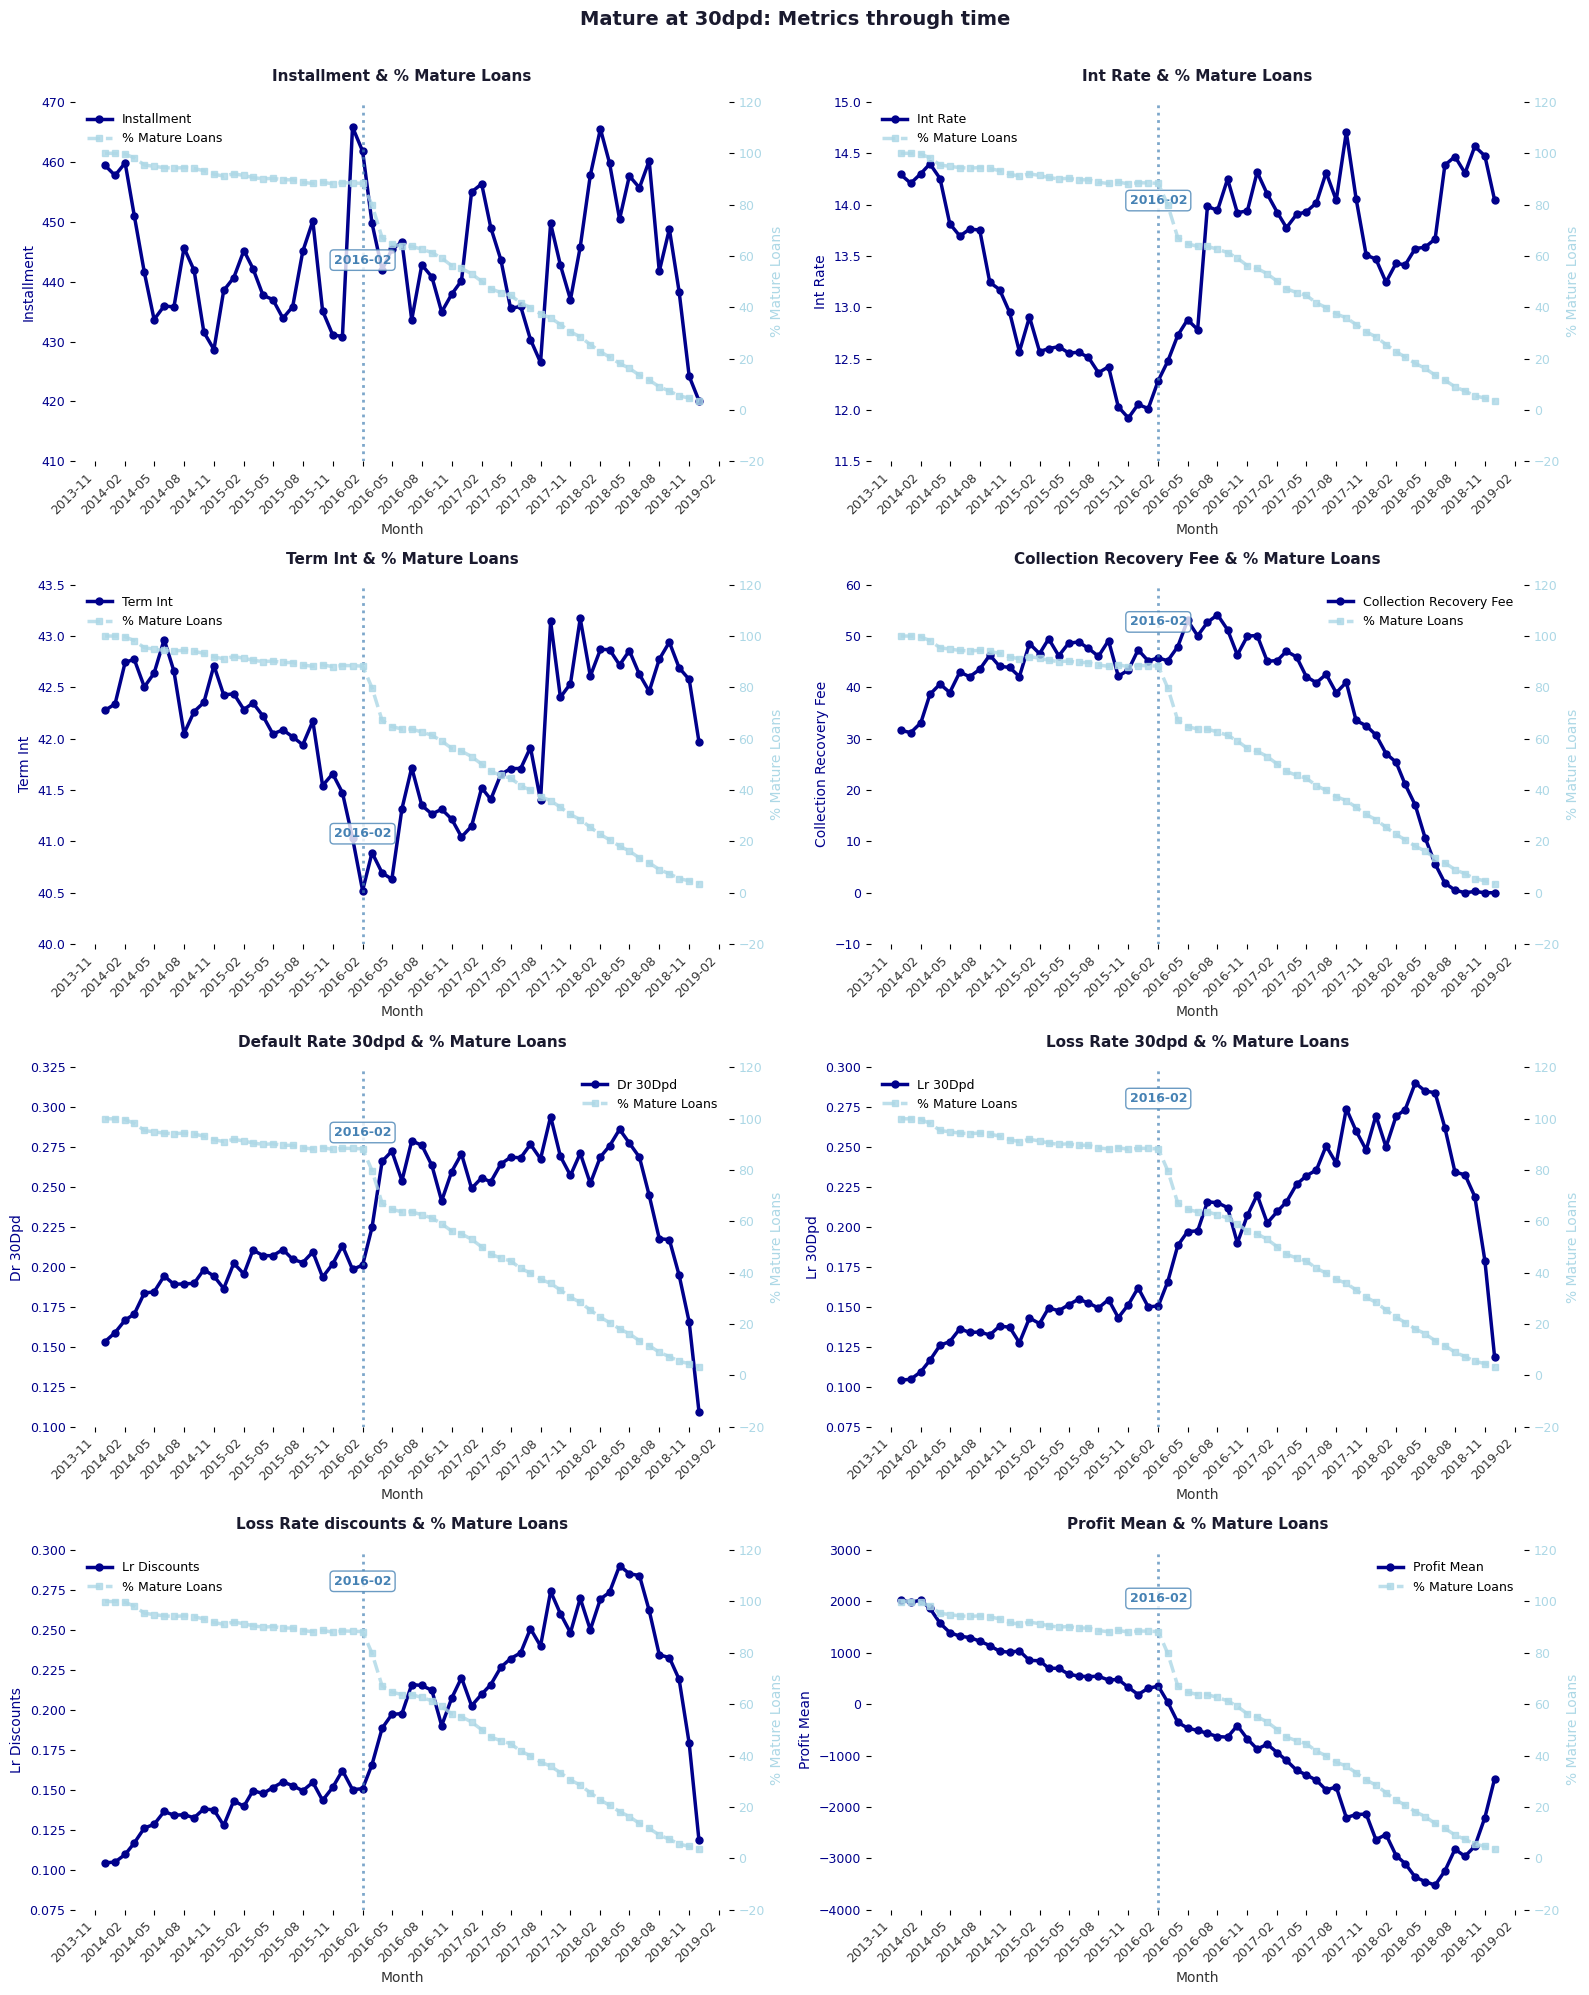


GRÁFICAS: Mature Default -> POST November 2013


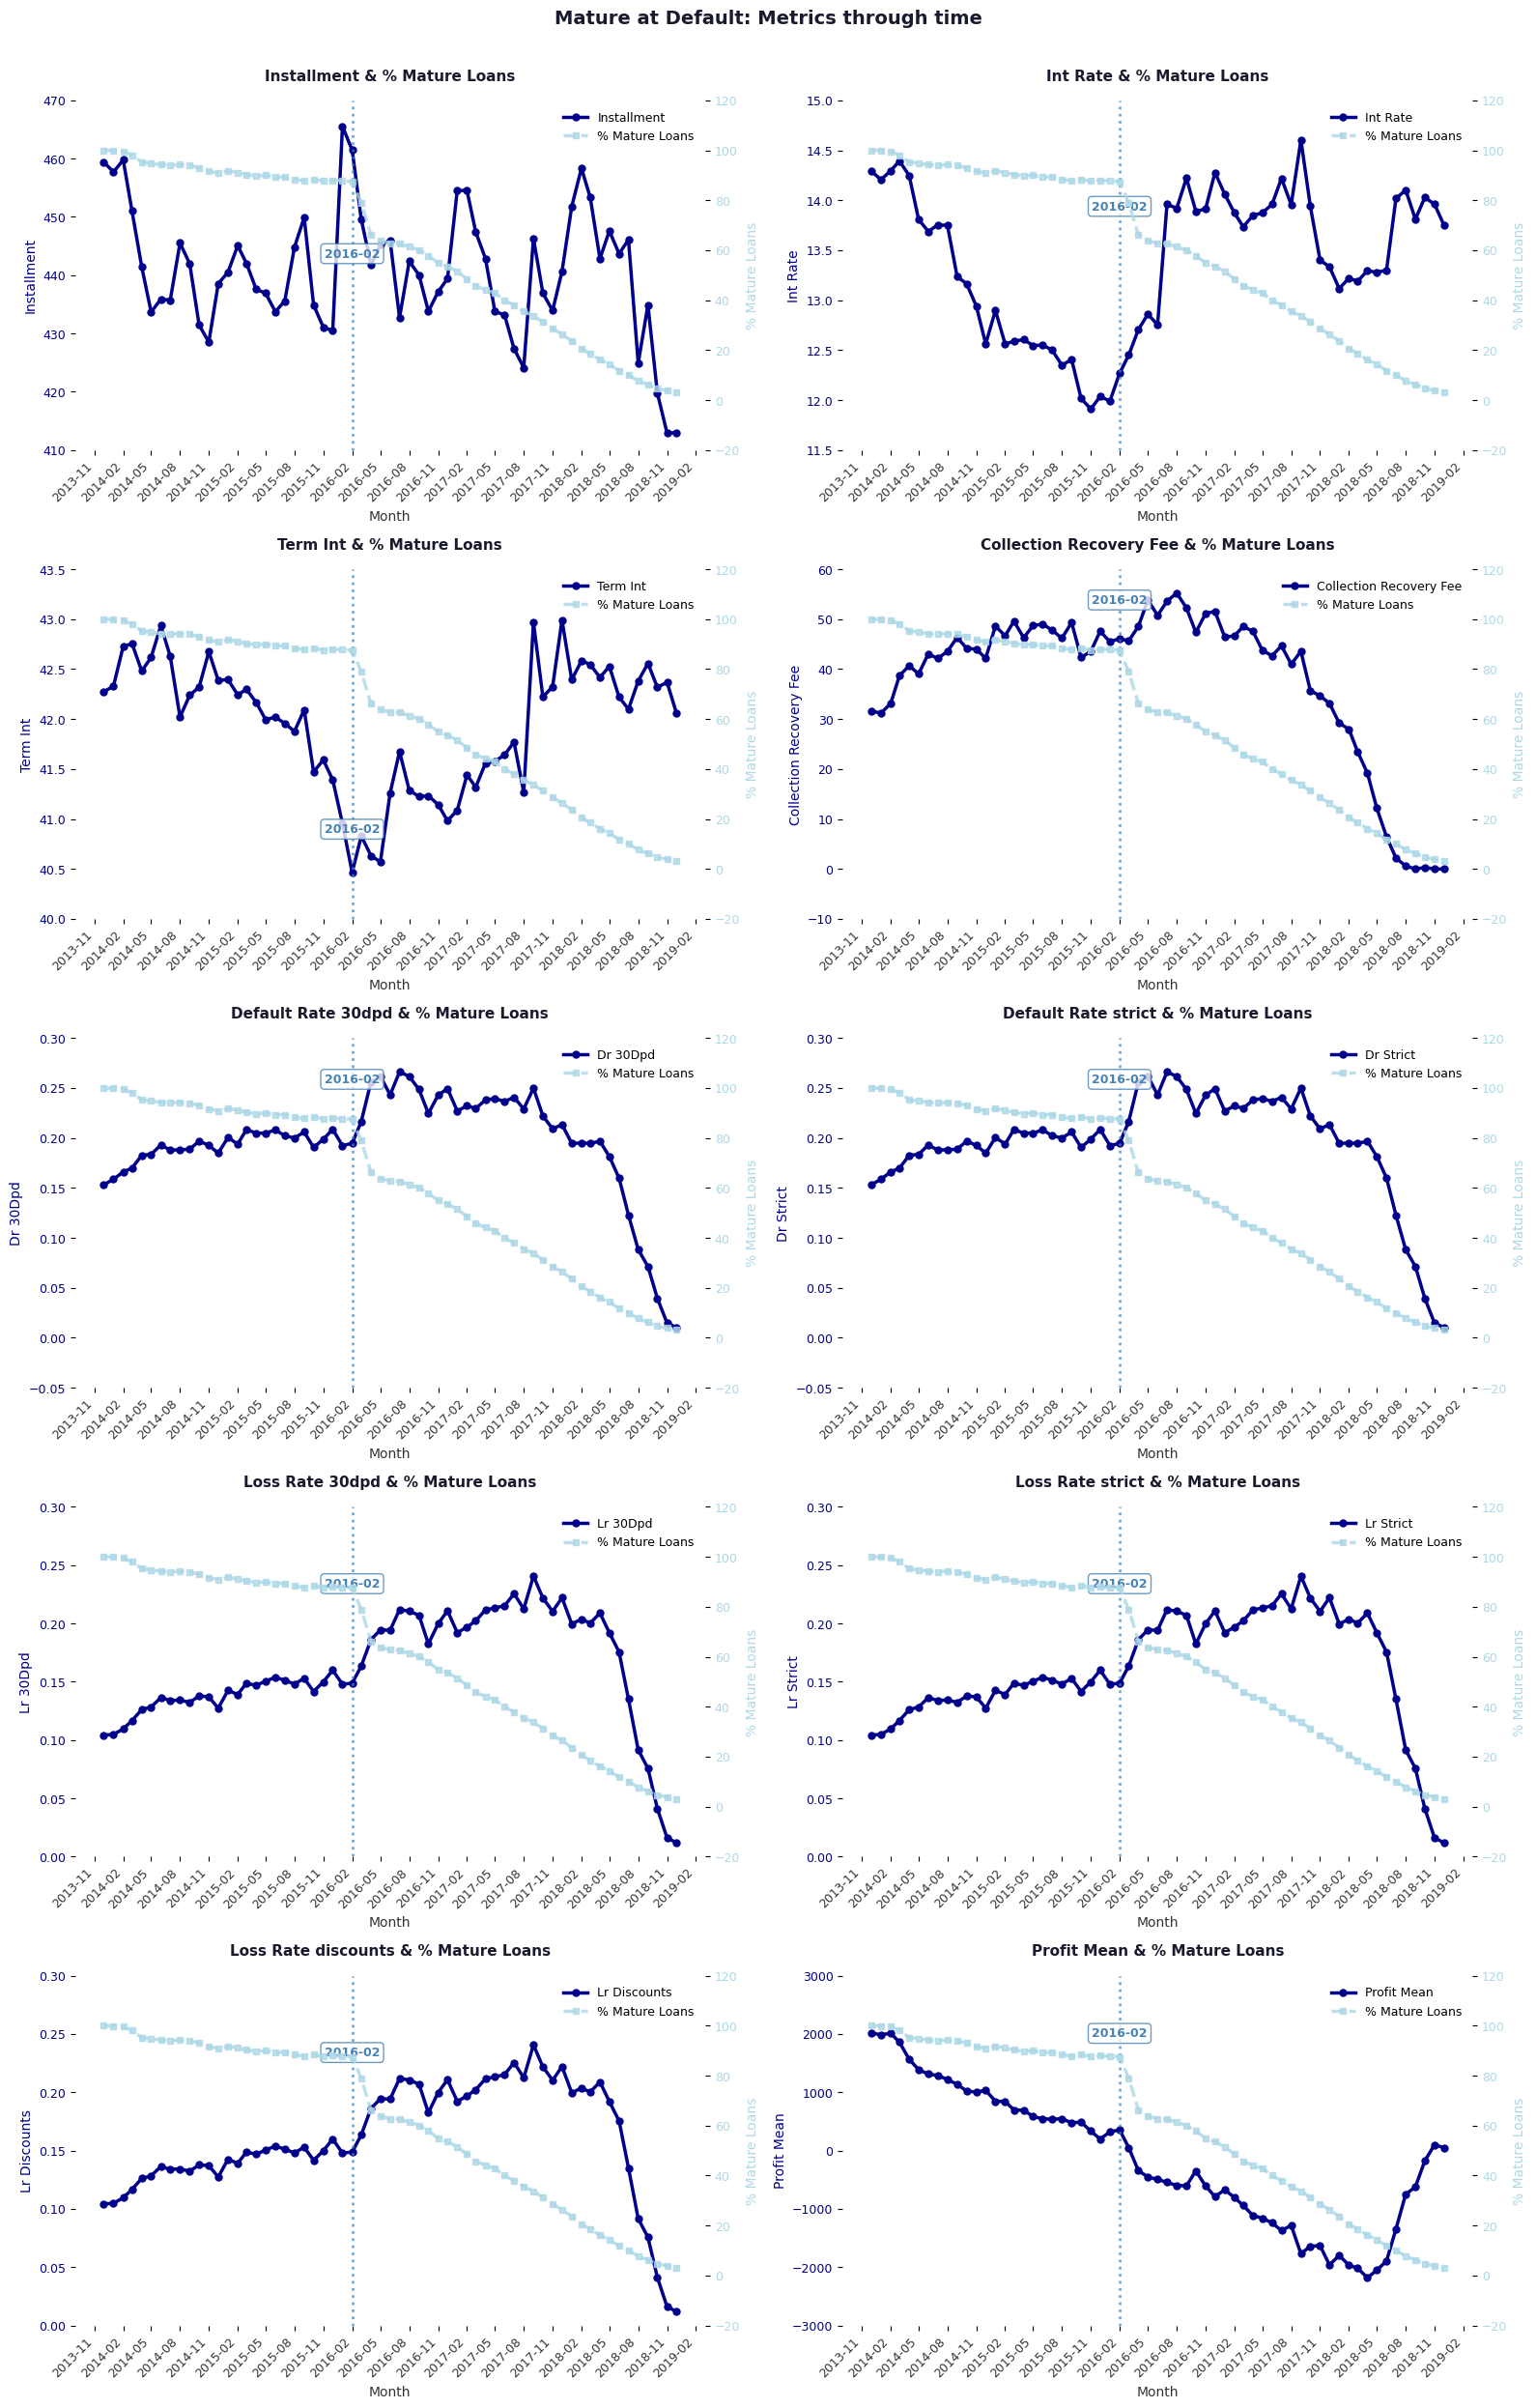

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

# Configurar estilo global limpio
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

def create_metric_plots(df, title_suffix):
    """Crea gráficas limpias para todas las métricas DR_, LR_, y profit_mean en una sola figura con 2 columnas"""
    # Identificar métricas
    metrics = [col for col in df.columns 
               if col in [
                'installment', 'int_rate', 'term_int', 'collection_recovery_fee', 'profit_mean'
                ] or col.startswith('DR_') or col.startswith('LR_')]
    
    if 'perc_loans_mature' not in df.columns:
        print(f"No se encontró 'perc_loans_mature' en el DataFrame para {title_suffix}")
        return
    
    # Convertir índice a datetime si es necesario
    if df.index.dtype == 'object':
        df.index = pd.to_datetime(df.index)
    
    # Colores: azul muy oscuro y azul grisáceo/tenue
    color_dark = 'darkblue'#'#1a1a2e'  # Azul muy oscuro
    color_light = 'lightblue'#'#6c7a89'  # Azul grisáceo/tenue
    color_vertical = 'steelblue'  # Otro tono de azul para la línea vertical
    
    # Encontrar la última fecha con al menos 80% de préstamos maduros
    mask_80pct = df['perc_loans_mature'] >= 0.8
    if mask_80pct.any():
        last_date_80pct = df.index[mask_80pct].max()
    else:
        last_date_80pct = None
    
    # Calcular número de filas necesarias (2 columnas)
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)
    
    # Crear figura única con subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    fig.patch.set_facecolor('white')
    
    # Aplanar axes si es necesario (cuando hay más de una fila)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    
    # Iterar sobre métricas y crear cada subplot
    for idx, metric in enumerate(metrics):
        ax1 = axes_flat[idx]
        
        # Eje principal - métrica (azul muy oscuro)
        ax1.plot(df.index, df[metric], color=color_dark, linewidth=2.5, 
                marker='o', markersize=5, label=metric.replace('_', ' ').title())
        ax1.set_xlabel('Month', fontsize=10, color='#333333')
        ax1.set_ylabel(metric.replace('_', ' ').title(), color=color_dark, fontsize=10, fontweight='medium')
        ax1.tick_params(axis='y', labelcolor=color_dark, labelsize=9)
        ax1.tick_params(axis='x', labelcolor='#333333', labelsize=9)
        
        # Eje secundario - perc_loans_mature (azul grisáceo)
        ax2 = ax1.twinx()
        ax2.plot(df.index, df['perc_loans_mature'] * 100, color=color_light, 
                linewidth=2.5, marker='s', markersize=5, linestyle='--', 
                label='% Mature Loans', alpha=0.8)
        ax2.set_ylabel('% Mature Loans', color=color_light, fontsize=10, fontweight='medium')
        ax2.tick_params(axis='y', labelcolor=color_light, labelsize=9)
        
        # Agregar línea vertical en la última fecha con >= 80% de préstamos maduros
        if last_date_80pct is not None:
            ax1.axvline(x=last_date_80pct, color=color_vertical, linewidth=2, 
                       linestyle=':', alpha=0.7)
            
            # Agregar texto con la fecha
            date_str = last_date_80pct.strftime('%Y-%m')
            # Obtener los límites del eje y para posicionar el texto
            y_min, y_max = ax1.get_ylim()
            # Posicionar el texto en la parte superior del gráfico
            ax1.text(last_date_80pct, y_max * 0.95, date_str, 
                    color=color_vertical, fontsize=9, fontweight='bold',
                    ha='center', va='top', rotation=0,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                             edgecolor=color_vertical, alpha=0.8))
        
        # Formatear fechas
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Remover todos los spines y líneas de ejes
        for ax in [ax1, ax2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.grid(False)
            ax.set_xticks(ax.get_xticks())
            ax.set_yticks(ax.get_yticks())
        
        # Título descriptivo
        metric_name = metric.replace('_', ' ').title()
        if metric.startswith('DR_'):
            metric_full_name = metric.replace('DR_', 'Default Rate ').replace('_', ' ')
        elif metric.startswith('LR_'):
            metric_full_name = metric.replace('LR_', 'Loss Rate ').replace('_', ' ')
        elif metric == 'profit_mean':
            metric_full_name = 'Profit Mean'
        else:
            metric_full_name = metric_name
            
        ax1.set_title(f'{metric_full_name} & % Mature Loans', 
                     fontsize=11, fontweight='bold', color='#1a1a2e', pad=15)
        
        # Leyenda limpia
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, 
                  loc='best', frameon=False, fontsize=9)
    
    # Ocultar subplots vacíos
    for idx in range(n_metrics, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    # Título general de la figura
    fig.suptitle(f'{title_suffix}: Metrics through time', 
                 fontsize=14, fontweight='bold', color='#1a1a2e', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# Generar gráficas
print("="*70)
print("GRÁFICAS: Mature 30dpd -> POST November 2013")
print("="*70)
create_metric_plots(gbtmp_01_mature_30dpd, "Mature at 30dpd")

print("\n" + "="*70)
print("GRÁFICAS: Mature Default -> POST November 2013")
print("="*70)
create_metric_plots(gbtmp_01_mature_default, "Mature at Default")

## Comments
- There is a important change on the percentage of mature loans from February 2016, that means that using loans with `issue_d` after that would put noise in the results, the metrics and the interpretation

- In my experience, it could be a good reference to have at least the 80% of mature loans. So, I would use to the training and out of time samples data between November 2013 and February 2016.

     - For another round of experiments, I would try with loans of previous years in order to train and test (oot) with periods of 36 or 60 months which are the two different terms offered.

- In the mean time, for the window we'll use, the Default Rate metrics, seems pretty stable, which is good for us and to felt confident about taking one of those as target.

- I got a little worried because, even for that period of time, the metrics related with amount, such as Loss rate and profit, didn't look stable to me. After some "zoom in"'s I found out that the interest rate and the term weren't either, since both kept decreasing through the months and it makes total sense that could be the real reason why the profits decreased and the losses increased. So, the best way (more fair) to compare performances would be using Default Rate, which is pretty stable for that same window of time.

- At the same time, we'll keep out the training dataset features regarding the current loan's amount, term and interest rate since those could be given after the risk evaluation and, even they would be settle before, they might be affected by some other models such offering, credit capacity, tenure or pricing models, which could be one of the reasons why we're seeing the behaviour on interest rate.

- In order to have at least a complete year for training and at least six months for out of time, and with the consideration of not taking anything after February 20216, I will experiment with three training windows of time:
     - training: November 2013 - December 2014 & oot: January 2015 - December 2015, given each sample, an one complete year
     - training: November 2013 - February 2015 & oot: March 2015 - February 2016, given a little more data to training, and keeping the last year to OOT
     - training: November 2013 - July 2015 & oot: August 2015 - February 2016, sacrifing a little of the OOT sample, in exchange of training with more data and as much recent as possible



In [24]:
sure_to_not_include.append("term_int")

# Feature Eng - P1

- I'm gonna build the features enlisted at *New Features ideas*

In [25]:
df_old01= df_old00[df_old00['post_20131105']==True].assign(
    
    fico_range_mean = lambda x: (x['fico_range_low'] + x['fico_range_high'])/2,
    tot_cur_bal_per_installment = lambda x: np.where(
        x['open_act_il'] != 0,
        x['tot_cur_bal']/x['open_act_il'],
        np.nan
    ),
    perc_bc_sats = lambda x: np.where(
        x['num_actv_bc_tl'] != 0,
        x['num_bc_sats']/x['num_actv_bc_tl'],
        np.nan
    ),
    perc_acc_now_delinq = lambda x: np.where(
        x['open_acc'] != 0,
        x['acc_now_delinq']/x['open_acc'],
        np.nan
    ),
    perc_acc_120dpd_2m = lambda x : np.where(
        x['open_acc'] != 0,
        x['num_tl_120dpd_2m']/x['open_acc'],
        np.nan
    ),
    perc_acc_30dpd = lambda x: np.where(
        x['open_acc'] != 0,
        x['num_tl_30dpd']/x['open_acc'],
        np.nan
    ),
    perc_acc_90g_dpd_24m = lambda x: np.where(
        x['open_acc'] != 0,
        x['num_tl_90g_dpd_24m']/x['open_acc'],
        np.nan
    ),
    perc_acc_op_past_12m = lambda x: np.where(
        x['open_acc'] != 0,
        x['num_tl_op_past_12m']/x['open_acc'],
        np.nan
    ),
    sec_app_fico_range_mean = lambda x: (x['sec_app_fico_range_low'] + x['sec_app_fico_range_high'])/2,
)

sure_new_features = [
    'fico_range_mean',
    'tot_cur_bal_per_installment',
    'perc_bc_sats',
    'perc_acc_now_delinq',
    'perc_acc_120dpd_2m',
    'perc_acc_30dpd',
    'perc_acc_90g_dpd_24m',
    'perc_acc_op_past_12m',
    'sec_app_fico_range_mean',
]

df_old01[key_columns+[
    'pre_LR__30dpd','pre_LR__strict','pre_LR__discounts','profit',
]+[
    'fico_range_low','fico_range_high',
    'tot_cur_bal_per_installment', 'tot_cur_bal', 'open_act_il',
    'perc_bc_sats', 'num_bc_sats', 'num_actv_bc_tl',
    'perc_acc_now_delinq', 'acc_now_delinq', 'open_acc',
    'perc_acc_120dpd_2m', 'num_tl_120dpd_2m', 'open_acc',
    'perc_acc_30dpd', 'num_tl_30dpd', 'open_acc',
    'perc_acc_90g_dpd_24m', 'num_tl_90g_dpd_24m', 'open_acc',
    'perc_acc_op_past_12m', 'num_tl_op_past_12m', 'open_acc',
    'sec_app_fico_range_mean', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
    #'loan_amnt','total_pymnt','total_rec_int','total_rec_late_fee','total_rec_prncp'
    ]]

,id,issue_d,post_20131105,installment,int_rate,collection_recovery_fee,term,loan_status,loan_amnt,total_pymnt,total_rec_int,total_rec_late_fee,total_rec_prncp,member_id,is_paid_strict,is_paid_prior_30dpd,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit,pre_LR__30dpd,pre_LR__strict,pre_LR__discounts,profit,fico_range_low,fico_range_high,tot_cur_bal_per_installment,tot_cur_bal,open_act_il,perc_bc_sats,num_bc_sats,num_actv_bc_tl,perc_acc_now_delinq,acc_now_delinq,open_acc,perc_acc_120dpd_2m,num_tl_120dpd_2m,open_acc,perc_acc_30dpd,num_tl_30dpd,open_acc,perc_acc_90g_dpd_24m,num_tl_90g_dpd_24m,open_acc,perc_acc_op_past_12m,num_tl_op_past_12m,open_acc,sec_app_fico_range_mean,sec_app_fico_range_low,sec_app_fico_range_high
0,68407277,2015-12-01,True,123.03,13.99,0.0,36 months,Fully Paid,3600.0,4421.723917,821.72,0.00,3600.00,NaN,1.0,1.0,0.00,0.00,0.00,821.723917,0.00,0.00,0.00,821.723917,675.0,679.0,72452.000000,144904.0,2.0,1.000000,2.0,2.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.428571,3.0,7.0,NaN,NaN,NaN
1,68355089,2015-12-01,True,820.28,11.99,0.0,36 months,Fully Paid,24700.0,25679.660000,979.66,0.00,24700.00,NaN,1.0,1.0,0.00,0.00,0.00,979.660000,0.00,0.00,0.00,979.660000,715.0,719.0,204396.000000,204396.0,1.0,2.600000,13.0,5.0,0.0,0.0,22.0,0.0,0.0,22.0,0.0,0.0,22.0,0.0,0.0,22.0,0.090909,2.0,22.0,NaN,NaN,NaN
2,68341763,2015-12-01,True,432.66,10.78,0.0,60 months,Fully Paid,20000.0,22705.924294,2705.92,0.00,20000.00,NaN,1.0,1.0,0.00,0.00,0.00,2705.924294,0.00,0.00,0.00,2705.924294,695.0,699.0,189699.000000,189699.0,1.0,1.000000,2.0,2.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,6.0,0.0,0.0,6.0,0.000000,0.0,6.0,NaN,NaN,NaN
3,66310712,2015-12-01,True,829.90,14.85,0.0,60 months,Current,35000.0,31464.010000,12361.66,0.00,19102.35,NaN,NaN,NaN,NaN,NaN,15897.65,-3535.990000,NaN,NaN,15897.65,-3535.990000,785.0,789.0,301500.000000,301500.0,1.0,2.000000,8.0,4.0,0.0,0.0,13.0,0.0,0.0,13.0,0.0,0.0,13.0,0.0,0.0,13.0,0.076923,1.0,13.0,NaN,NaN,NaN
4,68476807,2015-12-01,True,289.91,22.45,0.0,60 months,Fully Paid,10400.0,11740.500000,1340.50,0.00,10400.00,NaN,1.0,1.0,0.00,0.00,0.00,1340.500000,0.00,0.00,0.00,1340.500000,695.0,699.0,110576.666667,331730.0,3.0,1.250000,5.0,4.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.333333,4.0,12.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,2016-10-01,True,543.50,12.79,0.0,60 months,Current,24000.0,15760.500000,6047.89,0.00,9712.61,NaN,NaN,NaN,NaN,NaN,14287.39,-8239.500000,NaN,NaN,14287.39,-8239.500000,665.0,669.0,52211.000000,104422.0,2.0,NaN,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,0.600000,3.0,5.0,NaN,NaN,NaN
2260695,88977788,2016-10-01,True,515.74,10.49,0.0,60 months,Current,24000.0,15008.530000,4959.95,0.00,10048.58,NaN,NaN,NaN,NaN,NaN,13951.42,-8991.470000,NaN,NaN,13951.42,-8991.470000,695.0,699.0,35029.500000,140118.0,4.0,1.400000,7.0,5.0,0.0,0.0,24.0,0.0,0.0,24.0,0.0,0.0,24.0,0.0,0.0,24.0,0.000000,0.0,24.0,NaN,NaN,NaN
2260696,88985880,2016-10-01,True,859.56,10.49,0.0,60 months,Current,40000.0,24903.930000,8156.52,0.00,16747.41,NaN,NaN,NaN,NaN,NaN,23252.59,-15096.070000,NaN,NaN,23252.59,-15096.070000,705.0,709.0,14199.000000,28398.0,2.0,1.000000,2.0,2.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,5.0,1.4,7.0,5.0,0.000000,0.0,5.0,NaN,NaN,NaN
2260697,88224441,2016-10-01,True,564.56,14.49,0.0,60 months,Charged Off,24000.0,6755.400000,3233.49,0.00,3521.91,NaN,0.0,0.0,20478.09,20478.09,20478.09,-17244.600000,20478.09,20478.09,20478.09,-17244.600000,660.0,664.0,31213.000000,62426.0,2.0,1.000000,5.0,5.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,0.0,10.0,0.0,0.0,10.0,0.100000,1.0,10.0,NaN,NaN,NaN


# Feature Eng - P2 & Feature Reduction

## Handcrafted filters: non-numerics + raw→transformed columns

### Not sure features

In [26]:
# Extraer features numéricas de las listas de features

def extraer_features_numericas(df, lista_features, nombre_lista):
    """
    Extrae solo las features numéricas de una lista de features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame donde buscar las features
    lista_features : list
        Lista de nombres de features
    nombre_lista : str
        Nombre descriptivo de la lista (para mostrar en resultados)
    
    Returns:
    --------
    dict con información sobre las features numéricas encontradas
    """
    # Filtrar features que existen en el DataFrame
    features_disponibles = [f for f in lista_features if f in df.columns]
    features_no_encontradas = [f for f in lista_features if f not in df.columns]
    
    # Filtrar solo features numéricas
    features_numericas = []
    features_no_numericas = []
    
    for feature in features_disponibles:
        if pd.api.types.is_numeric_dtype(df[feature]):
            features_numericas.append(feature)
        else:
            features_no_numericas.append(feature)
    
    resultado = {
        'nombre_lista': nombre_lista,
        'total_en_lista': len(lista_features),
        'disponibles_en_df': len(features_disponibles),
        'no_encontradas': features_no_encontradas,
        'numericas': features_numericas,
        'no_numericas': features_no_numericas,
        'total_numericas': len(features_numericas)
    }
    
    return resultado

# Extraer features numéricas de las listas principales
# (asumiendo que las listas están definidas en celdas anteriores)
listas_features = {
    'sure_to_include_raw': sure_to_include_raw,
    'sure_to_include_for_tranformation': sure_to_include_for_tranformation,
    'not_sure_to_include': not_sure_to_include
}

resultados = {}
todas_features_numericas = []

print("="*70)
print("EXTRACCIÓN DE FEATURES NUMÉRICAS")
print("="*70)

for nombre_lista, lista_features in listas_features.items():
    resultado = extraer_features_numericas(df_old01, lista_features, nombre_lista)
    resultados[nombre_lista] = resultado
    
    print(f"\n{nombre_lista.upper().replace('_', ' ')}:")
    print(f"  Total en lista: {resultado['total_en_lista']}")
    print(f"  Disponibles en DataFrame: {resultado['disponibles_en_df']}")
    print(f"  Features numéricas: {resultado['total_numericas']}")
    
    if resultado['no_encontradas']:
        print(f"  ⚠️  No encontradas en DataFrame ({len(resultado['no_encontradas'])}): {resultado['no_encontradas'][:5]}...")
    
    if resultado['no_numericas']:
        print(f"  📝 No numéricas ({len(resultado['no_numericas'])}): {resultado['no_numericas']}")
    
    if resultado['numericas']:
        print(f"  ✅ Features numéricas encontradas:")
        for i, feat in enumerate(resultado['numericas'], 1):
            dtype = df_old01[feat].dtype
            print(f"     {i:2d}. {feat} ({dtype})")
        todas_features_numericas.extend(resultado['numericas'])

# Resumen consolidado
print("\n" + "="*70)
print("RESUMEN CONSOLIDADO")
print("="*70)
print(f"Total de features numéricas encontradas: {len(todas_features_numericas)}")
print(f"\nLista completa de features numéricas:")
for i, feat in enumerate(todas_features_numericas, 1):
    print(f"  {i:3d}. {feat}")

# Crear variable con todas las features numéricas
features_numericas_consolidadas = todas_features_numericas.copy()
print(f"\n✅ Variable 'features_numericas_consolidadas' creada con {len(features_numericas_consolidadas)} features")


EXTRACCIÓN DE FEATURES NUMÉRICAS

SURE TO INCLUDE RAW:
  Total en lista: 82
  Disponibles en DataFrame: 82
  Features numéricas: 82
  ✅ Features numéricas encontradas:
      1. annual_inc (float64)
      2. dti (float64)
      3. delinq_2yrs (float64)
      4. fico_range_low (float64)
      5. fico_range_high (float64)
      6. inq_last_6mths (float64)
      7. mths_since_last_delinq (float64)
      8. mths_since_last_record (float64)
      9. open_acc (float64)
     10. pub_rec (float64)
     11. revol_util (float64)
     12. total_acc (float64)
     13. collections_12_mths_ex_med (float64)
     14. mths_since_last_major_derog (float64)
     15. annual_inc_joint (float64)
     16. dti_joint (float64)
     17. acc_now_delinq (float64)
     18. tot_coll_amt (float64)
     19. tot_cur_bal (float64)
     20. open_acc_6m (float64)
     21. open_act_il (float64)
     22. open_il_12m (float64)
     23. open_il_24m (float64)
     24. mths_since_rcnt_il (float64)
     25. total_bal_il (float64

Matriz de correlación:


,funded_amnt,revol_bal,policy_code,bc_open_to_buy,is_paid_strict
funded_amnt,1.000000,0.317421,NaN,0.205927,-0.065106
revol_bal,0.317421,1.000000,NaN,0.164301,0.022146
policy_code,NaN,NaN,NaN,NaN,NaN
bc_open_to_buy,0.205927,0.164301,NaN,1.000000,0.085732
is_paid_strict,-0.065106,0.022146,NaN,0.085732,1.000000



Correlaciones con is_paid_strict:


bc_open_to_buy    0.085732
revol_bal         0.022146
funded_amnt      -0.065106
policy_code            NaN
Name: is_paid_strict, dtype: float64

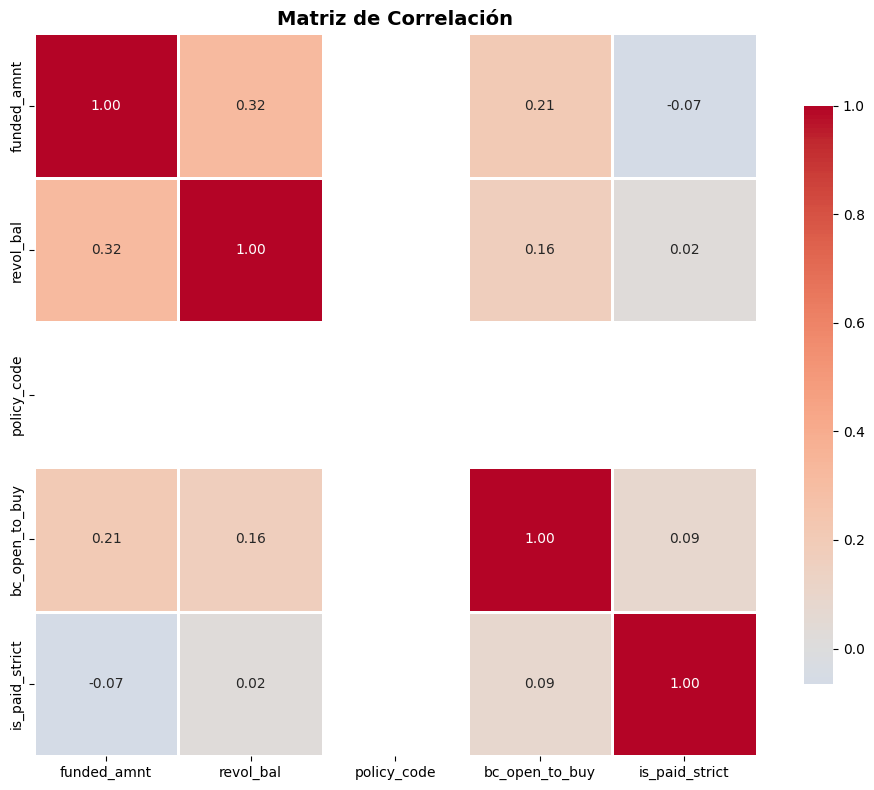


No se encontraron correlaciones con |r| >= 0.7


In [27]:
# Calcular correlación de una lista de columnas

variable_objetivo = 'is_paid_strict'  # o 'is_paid_prior_30dpd'

# Opción 1: Matriz de correlación completa entre todas las columnas de la lista
lista_columnas = [x for x in features_numericas_consolidadas if x in not_sure_to_include]#+[variable_objetivo]

# Filtrar solo las columnas que existen en el DataFrame
columnas_disponibles = [col for col in lista_columnas if col in df_old01.columns]

# Calcular matriz de correlación
matriz_correlacion = df_old01[columnas_disponibles+[variable_objetivo]].corr()
print("Matriz de correlación:")
display(matriz_correlacion)

# Opción 2: Correlación con una variable objetivo específica


# Filtrar columnas numéricas de la lista
columnas_numericas = [col for col in columnas_disponibles 
                     if pd.api.types.is_numeric_dtype(df_old01[col])]

if variable_objetivo in df_old01.columns:
    correlaciones_con_target = df_old01[columnas_numericas + [variable_objetivo]].corr()[variable_objetivo]
    correlaciones_con_target = correlaciones_con_target.drop(variable_objetivo).sort_values(ascending=False)
    print(f"\nCorrelaciones con {variable_objetivo}:")
    display(correlaciones_con_target)

# Opción 3: Visualizar matriz de correlación con heatmap
import seaborn as sns
import matplotlib.pyplot as plt

if len(columnas_disponibles) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_correlacion, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de Correlación', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Opción 4: Filtrar solo correlaciones altas (por ejemplo, > 0.7 o < -0.7)
umbral = 0.7
correlaciones_altas = []
for i in range(len(matriz_correlacion.columns)):
    for j in range(i+1, len(matriz_correlacion.columns)):
        valor = matriz_correlacion.iloc[i, j]
        if abs(valor) >= umbral:
            correlaciones_altas.append({
                'columna_1': matriz_correlacion.columns[i],
                'columna_2': matriz_correlacion.columns[j],
                'correlacion': valor
            })

if correlaciones_altas:
    df_corr_altas = pd.DataFrame(correlaciones_altas)
    print(f"\nCorrelaciones altas (|r| >= {umbral}):")
    display(df_corr_altas.sort_values('correlacion', key=abs, ascending=False))
else:
    print(f"\nNo se encontraron correlaciones con |r| >= {umbral}")


Matriz de correlación:


,funded_amnt,revol_bal,policy_code,bc_open_to_buy,is_paid_prior_30dpd
funded_amnt,1.000000,0.317421,NaN,0.205927,-0.071584
revol_bal,0.317421,1.000000,NaN,0.164301,0.023274
policy_code,NaN,NaN,NaN,NaN,NaN
bc_open_to_buy,0.205927,0.164301,NaN,1.000000,0.083340
is_paid_prior_30dpd,-0.071584,0.023274,NaN,0.083340,1.000000



Correlaciones con is_paid_prior_30dpd:


bc_open_to_buy    0.083340
revol_bal         0.023274
funded_amnt      -0.071584
policy_code            NaN
Name: is_paid_prior_30dpd, dtype: float64

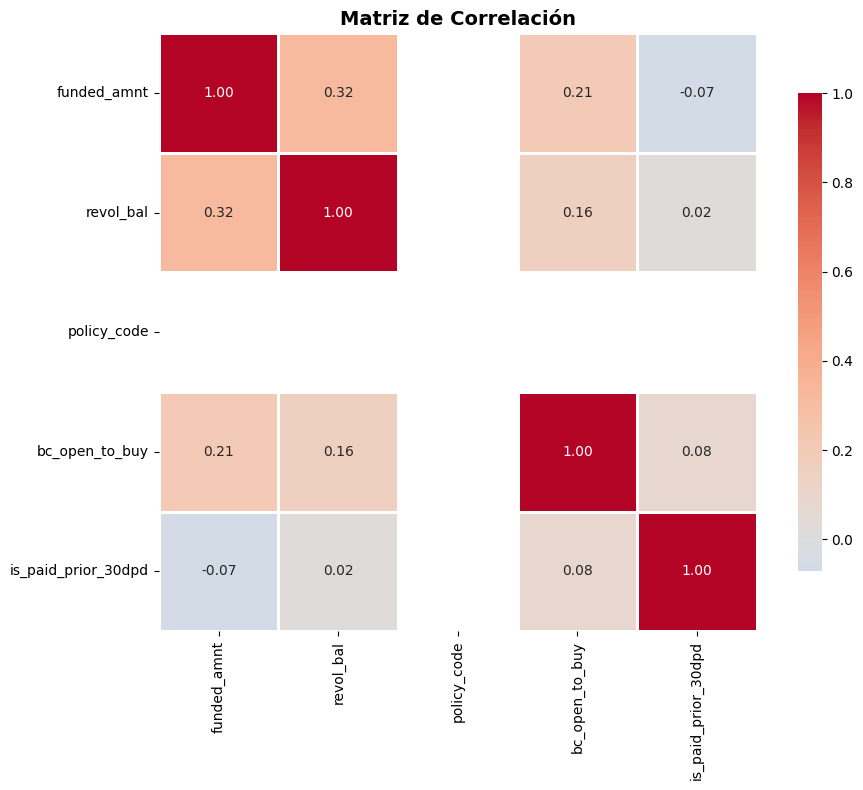


No se encontraron correlaciones con |r| >= 0.7


In [28]:
# Calcular correlación de una lista de columnas

variable_objetivo = 'is_paid_prior_30dpd' # 'is_paid_strict'

# Opción 1: Matriz de correlación completa entre todas las columnas de la lista
lista_columnas = [x for x in features_numericas_consolidadas if x in not_sure_to_include]#+[variable_objetivo]

# Filtrar solo las columnas que existen en el DataFrame
columnas_disponibles = [col for col in lista_columnas if col in df_old01.columns]

# Calcular matriz de correlación
matriz_correlacion = df_old01[columnas_disponibles+[variable_objetivo]].corr()
print("Matriz de correlación:")
display(matriz_correlacion)

# Opción 2: Correlación con una variable objetivo específica


# Filtrar columnas numéricas de la lista
columnas_numericas = [col for col in columnas_disponibles 
                     if pd.api.types.is_numeric_dtype(df_old01[col])]

if variable_objetivo in df_old01.columns:
    correlaciones_con_target = df_old01[columnas_numericas + [variable_objetivo]].corr()[variable_objetivo]
    correlaciones_con_target = correlaciones_con_target.drop(variable_objetivo).sort_values(ascending=False)
    print(f"\nCorrelaciones con {variable_objetivo}:")
    display(correlaciones_con_target)

# Opción 3: Visualizar matriz de correlación con heatmap
import seaborn as sns
import matplotlib.pyplot as plt

if len(columnas_disponibles) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_correlacion, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de Correlación', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Opción 4: Filtrar solo correlaciones altas (por ejemplo, > 0.7 o < -0.7)
umbral = 0.7
correlaciones_altas = []
for i in range(len(matriz_correlacion.columns)):
    for j in range(i+1, len(matriz_correlacion.columns)):
        valor = matriz_correlacion.iloc[i, j]
        if abs(valor) >= umbral:
            correlaciones_altas.append({
                'columna_1': matriz_correlacion.columns[i],
                'columna_2': matriz_correlacion.columns[j],
                'correlacion': valor
            })

if correlaciones_altas:
    df_corr_altas = pd.DataFrame(correlaciones_altas)
    print(f"\nCorrelaciones altas (|r| >= {umbral}):")
    display(df_corr_altas.sort_values('correlacion', key=abs, ascending=False))
else:
    print(f"\nNo se encontraron correlaciones con |r| >= {umbral}")


In [29]:
df_old01.groupby('policy_code',dropna=False).agg(
    {
        'is_paid_strict': 'mean',
        'is_paid_prior_30dpd': 'mean'
    }
).sort_values('is_paid_strict', ascending=False)


,is_paid_strict,is_paid_prior_30dpd
policy_code,,
1.0,0.791983,0.777248


In [30]:
df_old01['policy_code'].value_counts()

policy_code
1.0    2044972
Name: count, dtype: int64

- From the set of *not that sure to include*-features, all have a low correlation with both targets
- The feature `policy_code` has only one value, so will not use it
- The feature of `founded_amnt`will not be included neither because the criteria of not using loan amount, interest and terms features

In [31]:
print(df_old01['emp_title'].nunique())
print(df_old01['emp_title'].isnull().sum())
print(df_old01['emp_title'].nunique()/df_old01.shape[0])
print(df_old01['emp_title'].isnull().mean())

389455
153703
0.19044515034924683
0.07516142030306527


- `emp_title` definitly will not be included because the high cardinality. In the future would be interesting to see if some aggrupation about the job title increase improvement.

In [32]:
sure_to_not_include += ['emp_title','policy_code','founded_amnt']
sure_to_include_raw += ['revol_bal','bc_open_to_buy']#+=# sure_to_not_include

### Sure to include for tranformation

In [33]:
print(df_old01[sure_to_include_for_tranformation].dtypes)
display(df_old01[sure_to_include_for_tranformation])

emp_length                   object
home_ownership               object
verification_status          object
purpose                      object
earliest_cr_line             object
application_type             object
verification_status_joint    object
sec_app_earliest_cr_line     object
dtype: object


,emp_length,home_ownership,verification_status,purpose,earliest_cr_line,application_type,verification_status_joint,sec_app_earliest_cr_line
0,10+ years,MORTGAGE,Not Verified,debt_consolidation,Aug-2003,Individual,NaN,NaN
1,10+ years,MORTGAGE,Not Verified,small_business,Dec-1999,Individual,NaN,NaN
2,10+ years,MORTGAGE,Not Verified,home_improvement,Aug-2000,Joint App,Not Verified,NaN
3,10+ years,MORTGAGE,Source Verified,debt_consolidation,Sep-2008,Individual,NaN,NaN
4,3 years,MORTGAGE,Source Verified,major_purchase,Jun-1998,Individual,NaN,NaN
...,...,...,...,...,...,...,...,...
2260694,7 years,MORTGAGE,Source Verified,home_improvement,Dec-1999,Individual,NaN,NaN
2260695,10+ years,MORTGAGE,Not Verified,debt_consolidation,Feb-1991,Individual,NaN,NaN
2260696,9 years,MORTGAGE,Verified,debt_consolidation,Feb-1995,Individual,NaN,NaN
2260697,6 years,RENT,Not Verified,debt_consolidation,Jul-1999,Individual,NaN,NaN


In [34]:
vartmp = 'home_ownership'
print(f"{'==='*10} {vartmp} {'==='*10}")
print(df_old01[vartmp].value_counts())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())

vartmp = 'verification_status'
print(f"{'==='*10} {vartmp} {'==='*10}")
print(df_old01[vartmp].value_counts())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())


vartmp = 'purpose'
print(f"{'==='*10} {vartmp} {'==='*10}")
print(df_old01[vartmp].value_counts())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())


vartmp = 'application_type'
print(f"{'==='*10} {vartmp} {'==='*10}")
print(df_old01[vartmp].value_counts())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())


vartmp = 'verification_status_joint'
print(f"{'==='*10} {vartmp} {'==='*10}")
print(df_old01[vartmp].value_counts())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())

============================== home_ownership ==============================
home_ownership
MORTGAGE    1003473
RENT         804781
OWN          235718
ANY             996
NONE              4
Name: count, dtype: int64
0
0.0
============================== verification_status ==============================
verification_status
Source Verified    838872
Not Verified       670862
Verified           535238
Name: count, dtype: int64
0
0.0
============================== purpose ==============================
purpose
debt_consolidation    1155364
credit_card            472457
home_improvement       137631
other                  126808
major_purchase          44700
medical                 25353
car                     20539
small_business          20119
vacation                14281
moving                  13805
house                   12669
renewable_energy         1221
wedding                    23
educational                 2
Name: count, dtype: int64
0
0.0
============================== app

- All will be categorical features to consider, except `verification_status_joint` because it has 94% of `NaN`s

In [35]:
pre_categorical_features = [
    'application_type',
    'purpose',
    'verification_status',
    'home_ownership'
    ]

sure_to_not_include.append('verification_status_joint')

In [36]:
df_old01['earliest_cr_line'] = pd.to_datetime(df_old01['earliest_cr_line'], format='%b-%Y', errors='coerce')
df_old01['sec_app_earliest_cr_line'] = pd.to_datetime(df_old01['sec_app_earliest_cr_line'], format='%b-%Y', errors='coerce')

df_old01 = df_old01.assign(
    emp_length_num = lambda x: x['emp_length'].str.extract('(\d+)').astype(float),
    years_since_earliest_cr_line = lambda x: (x['issue_d'] - x['earliest_cr_line']).dt.days/365,
    years_since_sec_app_earliest_cr_line = lambda x: (x['issue_d'] - x['sec_app_earliest_cr_line']).dt.days/365
)


vartmp = 'emp_length_num'
print(f"{'==='*30}{vartmp}")
print(df_old01[vartmp].value_counts())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())


vartmp = 'years_since_earliest_cr_line'
print(f"{'==='*30}{vartmp}")
print(df_old01[vartmp].nunique())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())


vartmp = 'years_since_sec_app_earliest_cr_line'
print(f"{'==='*30}{vartmp}")
print(df_old01[vartmp].nunique())
print(df_old01[vartmp].isnull().sum())
print(df_old01[vartmp].isnull().mean())




==========================================================================================emp_length_num
emp_length_num
10.0    682553
1.0     307143
2.0     184029
3.0     163616
5.0     122973
4.0     122832
6.0      89152
8.0      82062
7.0      80475
9.0      71524
Name: count, dtype: int64
138613
0.06778234616415287
==========================================================================================years_since_earliest_cr_line
2867
0
0.0
==========================================================================================years_since_sec_app_earliest_cr_line
2002
1936951
0.947177271864847


- `emp_length_num` & `years_since_earliest_cr_line` will be consider as features, but `years_since_sec_app_earliest_cr_line` will be removed because the 94% of `NaN`s

In [37]:
sure_to_include_transformed = ['emp_length_num','years_since_earliest_cr_line']

sure_to_not_include +=[
    'emp_length',
    'earliest_cr_line',
    'sec_app_earliest_cr_line',
    'years_since_sec_app_earliest_cr_line'
    ]

In [38]:
sure_to_not_include = list(set(sure_to_not_include))

## Summary of columns

In [39]:
print(f"{'='*50} \n list_targets")
print(list_targets)

print(f"{'='*50} \n list_for_metrics")
print(list_for_metrics)

print(f"{'='*30} \n sure_to_include_raw")
print(sure_to_include_raw)
print(f"{'='*30}\n sure_to_include_transformed")
print(sure_to_include_transformed)
print(f"{'='*30}\n pre_categorical_features")
print(pre_categorical_features)
print(f"{'='*30}\n sure_new_features")
print(sure_new_features)
print(f"{'='*30}\n sure_to_not_include")
print(sure_to_not_include)

 list_targets
['is_paid_strict', 'is_paid_prior_30dpd']
 list_for_metrics
['is_paid_strict', 'is_paid_prior_30dpd', 'pre_LR__30dpd', 'pre_LR__strict', 'pre_LR__discounts', 'profit']
 sure_to_include_raw
['annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_rece

## Filters-Kit for numeric potential features

In [40]:
# Feature Reduction Function - VERSIÓN CORREGIDA
# Esta función reduce features basándose en missings, PSI, varianza y correlación
# ORDEN DE FILTROS: 1. Missings, 2. PSI, 3. Varianza, 4. Correlaciones

def calculate_psi(expected, actual, bins=10):
    """
    Calcula el Population Stability Index (PSI) entre dos distribuciones.
    
    Parameters:
    -----------
    expected : array-like
        Distribución esperada (período base)
    actual : array-like
        Distribución actual (período a comparar)
    bins : int
        Número de bins para discretizar (default: 10)
    
    Returns:
    --------
    float
        Valor de PSI. Valores típicos:
        - PSI < 0.1: Sin cambio significativo
        - 0.1 <= PSI < 0.25: Cambio moderado
        - PSI >= 0.25: Cambio significativo
    """
    # Remover valores nulos
    expected_clean = np.array(expected[~pd.isna(expected)])
    actual_clean = np.array(actual[~pd.isna(actual)])
    
    if len(expected_clean) == 0 or len(actual_clean) == 0:
        return np.nan
    
    # Calcular bins basados en la distribución esperada
    if len(expected_clean) < bins:
        bins = max(2, len(expected_clean) // 2)
    
    try:
        # Para variables numéricas
        if pd.api.types.is_numeric_dtype(expected_clean):
            _, bin_edges = np.histogram(expected_clean, bins=bins)
            # Asegurar que los bins cubran también los valores actuales
            min_val = min(expected_clean.min(), actual_clean.min())
            max_val = max(expected_clean.max(), actual_clean.max())
            bin_edges = np.linspace(min_val, max_val, bins + 1)
            
            expected_percents = np.histogram(expected_clean, bins=bin_edges)[0] / len(expected_clean)
            actual_percents = np.histogram(actual_clean, bins=bin_edges)[0] / len(actual_clean)
        else:
            # Para variables categóricas
            expected_counts = pd.Series(expected_clean).value_counts(normalize=True)
            actual_counts = pd.Series(actual_clean).value_counts(normalize=True)
            
            # Obtener todas las categorías
            all_categories = set(expected_counts.index) | set(actual_counts.index)
            
            expected_percents = np.array([expected_counts.get(cat, 0) for cat in all_categories])
            actual_percents = np.array([actual_counts.get(cat, 0) for cat in all_categories])
        
        # Evitar división por cero
        expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
        actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
        
        # Calcular PSI
        psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
        
        return psi
    except Exception as e:
        return np.nan


def reduce_features(
    df,
    features_list,
    date_column,
    time_window,
    psi_threshold=0.25,
    variance_threshold=1e-6,
    missing_threshold=0.5,
    correlation_threshold=0.95,
    verbose=True
):
    """
    Reduce features basándose en múltiples criterios:
    - Porcentaje de missings
    - PSI (Population Stability Index)
    - Varianza mínima
    - Correlación entre features
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos
    features_list : list
        Lista de nombres de features a evaluar
    date_column : str
        Nombre de la columna de fecha para definir ventanas de tiempo
    time_window : dict
        Diccionario con las ventanas de tiempo para calcular PSI.
        Formato: {'base_start': '2013-11-01', 'base_end': '2014-12-31',
                  'actual_start': '2015-01-01', 'actual_end': '2015-12-31'}
    psi_threshold : float
        Threshold de PSI. Features con PSI >= threshold serán eliminadas (default: 0.25)
    variance_threshold : float
        Threshold de varianza mínima. Features con varianza < threshold serán eliminadas (default: 1e-6)
    missing_threshold : float
        Threshold de porcentaje de missings. Features con % missings > threshold serán eliminadas (default: 0.5)
    correlation_threshold : float
        Threshold de correlación. Features con correlación >= threshold serán eliminadas (default: 0.95)
    verbose : bool
        Si True, imprime información sobre el proceso (default: True)
    
    Returns:
    --------
    dict
        Diccionario con:
        - 'selected_features': Lista de features seleccionadas
        - 'removed_features': Diccionario con features eliminadas por cada criterio
        - 'stats': DataFrame con estadísticas de cada feature
    """
    # Validar que las features existan en el DataFrame
    available_features = [f for f in features_list if f in df.columns]
    if len(available_features) != len(features_list):
        missing = set(features_list) - set(available_features)
        if verbose:
            print(f"Advertencia: Las siguientes features no están en el DataFrame: {missing}")
    
    features_to_evaluate = available_features.copy()
    
    if verbose:
        print(f"Evaluando {len(features_to_evaluate)} features...")
        print("="*70)
    
    # Convertir columna de fecha a datetime si es necesario
    if not pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])
    
    # Filtrar datos según ventana de tiempo
    base_mask = (df[date_column] >= time_window['base_start']) & (df[date_column] <= time_window['base_end'])
    actual_mask = (df[date_column] >= time_window['actual_start']) & (df[date_column] <= time_window['actual_end'])
    
    df_base = df[base_mask].copy()
    df_actual = df[actual_mask].copy()
    
    if verbose:
        print(f"Período base: {len(df_base)} registros")
        print(f"Período actual: {len(df_actual)} registros")
        print("="*70)
    
    # Inicializar diccionario de estadísticas
    stats = {}
    removed_by_psi = []
    removed_by_variance = []
    removed_by_missing = []
    removed_by_correlation = []
    
    # 1. Calcular porcentaje de missings
    if verbose:
        print("\n1. Calculando porcentaje de missings...")
    
    missing_pct = {}
    for feature in features_to_evaluate:
        if feature in df.columns:
            missing_count = df[feature].isna().sum()
            missing_pct_value = missing_count / len(df)
            missing_pct[feature] = missing_pct_value
            stats[feature] = {'missing_pct': missing_pct_value}
            
            if missing_pct_value > missing_threshold:
                removed_by_missing.append(feature)
                if verbose:
                    print(f"  - {feature}: {missing_pct_value*100:.2f}% missings (> {missing_threshold*100}%) - ELIMINADA")
    
    # Actualizar lista de features después de missings
    features_after_missing = [f for f in features_to_evaluate if f not in removed_by_missing]
    
    # 2. Calcular PSI para cada feature
    if verbose:
        print("\n2. Calculando PSI...")
    
    psi_values = {}
    for feature in features_after_missing:
        if feature in df_base.columns and feature in df_actual.columns:
            psi = calculate_psi(df_base[feature], df_actual[feature])
            psi_values[feature] = psi
            if feature in stats:
                stats[feature]['psi'] = psi
            else:
                stats[feature] = {'psi': psi}
            
            if not pd.isna(psi) and psi >= psi_threshold:
                removed_by_psi.append(feature)
                if verbose:
                    print(f"  - {feature}: PSI = {psi:.4f} (>= {psi_threshold}) - ELIMINADA")
        else:
            psi_values[feature] = np.nan
            if feature in stats:
                stats[feature]['psi'] = np.nan
            else:
                stats[feature] = {'psi': np.nan}
    
    # Actualizar lista de features después de PSI
    features_after_psi = [f for f in features_after_missing if f not in removed_by_psi]
    
    # 3. Calcular varianza
    if verbose:
        print(f"\n3. Calculando varianza (threshold: {variance_threshold})...")
    
    variance_values = {}
    for feature in features_after_psi:
        if feature in df.columns:
            # Solo calcular varianza para variables numéricas
            if pd.api.types.is_numeric_dtype(df[feature]):
                variance = df[feature].var()
                variance_values[feature] = variance
                if feature in stats:
                    stats[feature]['variance'] = variance
                else:
                    stats[feature] = {'variance': variance}
                
                if pd.isna(variance) or variance < variance_threshold:
                    removed_by_variance.append(feature)
                    if verbose:
                        print(f"  - {feature}: varianza = {variance:.6f} (< {variance_threshold}) - ELIMINADA")
            else:
                variance_values[feature] = np.nan
                if feature in stats:
                    stats[feature]['variance'] = np.nan
                else:
                    stats[feature] = {'variance': np.nan}
    
    # Actualizar lista de features después de varianza
    features_after_variance = [f for f in features_after_psi if f not in removed_by_variance]
    
    # 4. Eliminar features altamente correlacionadas
    if verbose:
        print(f"\n4. Eliminando features altamente correlacionadas (threshold: {correlation_threshold})...")
    
    # Filtrar solo features numéricas para correlación
    numeric_features = [f for f in features_after_variance 
                       if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    
    if len(numeric_features) > 1:
        # Calcular matriz de correlación
        corr_matrix = df[numeric_features].corr().abs()
        
        # Encontrar pares de features altamente correlacionadas
        upper_triangle = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )
        
        # Identificar features a eliminar (mantener la primera de cada par)
        to_remove_corr = set()
        for col in upper_triangle.columns:
            for idx in upper_triangle.index:
                if not pd.isna(upper_triangle.loc[idx, col]):
                    if upper_triangle.loc[idx, col] >= correlation_threshold:
                        # Eliminar la feature que aparece después en la lista
                        if numeric_features.index(idx) > numeric_features.index(col):
                            to_remove_corr.add(idx)
                        else:
                            to_remove_corr.add(col)
        
        removed_by_correlation = list(to_remove_corr)
        
        if verbose and removed_by_correlation:
            for feature in removed_by_correlation:
                # Encontrar con qué feature está correlacionada
                corr_pairs = []
                for other_feature in numeric_features:
                    if other_feature != feature and other_feature not in removed_by_correlation:
                        corr_val = corr_matrix.loc[feature, other_feature]
                        if not pd.isna(corr_val) and corr_val >= correlation_threshold:
                            corr_pairs.append(f"{other_feature} ({corr_val:.3f})")
                
                if corr_pairs:
                    print(f"  - {feature}: correlacionada con {', '.join(corr_pairs)} - ELIMINADA")
    
    # Features finales seleccionadas
    selected_features = [f for f in features_after_variance if f not in removed_by_correlation]
    
    # Crear DataFrame con estadísticas
    stats_df = pd.DataFrame(stats).T
    stats_df = stats_df.reindex(features_to_evaluate)
    
    # Resumen final
    if verbose:
        print("\n" + "="*70)
        print("RESUMEN DE REDUCCIÓN DE FEATURES")
        print("="*70)
        print(f"Features iniciales: {len(features_to_evaluate)}")
        print(f"Eliminadas por missings: {len(removed_by_missing)}")
        print(f"Eliminadas por PSI: {len(removed_by_psi)}")
        print(f"Eliminadas por varianza: {len(removed_by_variance)}")
        print(f"Eliminadas por correlación: {len(removed_by_correlation)}")
        print(f"Features finales seleccionadas: {len(selected_features)}")
        print("="*70)
    
    return {
        'selected_features': selected_features,
        'removed_features': {
            'psi': removed_by_psi,
            'variance': removed_by_variance,
            'missing': removed_by_missing,
            'correlation': removed_by_correlation
        },
        'stats': stats_df
    }


- We'll use the windows of time in which the training dataset is the longest:
    - training: November 2013 - July 2015 & oot: August 2015 - February 2016, sacrifing a little of the OOT sample, in exchange of training with more data and as much recent as possible
- And the numeric features we've enlisted above.
- And for the loans are, at least, mature to 30 days past due

In [41]:
df_old02 = df_old01[(
    (
        df_old01['mature_at_30dpd'] == True
        ) & (
        df_old01['issue_d'] >= '2013-11-01'
        ) & (
        df_old01['issue_d'] <= '2016-02-29'
        )
)]

In [42]:
# Ejemplo de uso:
time_window = {
    'base_start': '2013-11-01',
    'base_end': '2015-02-28',
    'actual_start': '2015-03-01',
    'actual_end': '2016-02-29'
}

features_list = sure_to_include_raw+sure_to_include_transformed+sure_new_features  # Tu lista de features

result = reduce_features(
    df=df_old02,
    features_list=features_list,
    date_column='issue_d',
    time_window=time_window,
    psi_threshold=0.25,
    variance_threshold=1e-5,
    missing_threshold=0.8,
    correlation_threshold=0.90,
    verbose=True
)

# Obtener features seleccionadas
selected_features = result['selected_features']

Evaluando 95 features...
Período base: 292449 registros
Período actual: 386408 registros

1. Calculando porcentaje de missings...
  - mths_since_last_record: 82.02% missings (> 80.0%) - ELIMINADA
  - annual_inc_joint: 99.80% missings (> 80.0%) - ELIMINADA
  - dti_joint: 99.81% missings (> 80.0%) - ELIMINADA
  - open_acc_6m: 87.85% missings (> 80.0%) - ELIMINADA
  - open_act_il: 87.85% missings (> 80.0%) - ELIMINADA
  - open_il_12m: 87.85% missings (> 80.0%) - ELIMINADA
  - open_il_24m: 87.85% missings (> 80.0%) - ELIMINADA
  - mths_since_rcnt_il: 88.18% missings (> 80.0%) - ELIMINADA
  - total_bal_il: 87.85% missings (> 80.0%) - ELIMINADA
  - il_util: 89.45% missings (> 80.0%) - ELIMINADA
  - open_rv_12m: 87.85% missings (> 80.0%) - ELIMINADA
  - open_rv_24m: 87.85% missings (> 80.0%) - ELIMINADA
  - max_bal_bc: 87.85% missings (> 80.0%) - ELIMINADA
  - all_util: 87.85% missings (> 80.0%) - ELIMINADA
  - inq_fi: 87.85% missings (> 80.0%) - ELIMINADA
  - total_cu_tl: 87.85% missings (> 

# Training model

## For one experiment

In [43]:
# Sistema de Experimentos de Modelos de Machine Learning
# Permite parametrizar múltiples aspectos del entrenamiento y evaluación

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)

# Intentar importar category_encoders para WOE
try:
    import category_encoders as ce
    CATEGORY_ENCODERS_AVAILABLE = True
except ImportError:
    CATEGORY_ENCODERS_AVAILABLE = False
    print("⚠️  category_encoders no está instalado. WOE encoding no estará disponible.")
    print("   Instala con: pip install category-encoders")
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from datetime import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Importar Optuna para optimización de hiperparámetros
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️  Optuna no está instalado. La optimización de hiperparámetros no estará disponible.")
    print("   Instala con: pip install optuna")

def run_model_experiment(
    df,
    train_window_start,
    train_window_end,
    oot_window_start,
    oot_window_end,
    date_column,
    maturity_column,
    target_column,
    features_list,
    categorical_features=None,
    train_test_split_ratio=0.8,
    algorithm='xgboost',
    use_class_weights=True,
    optimize_hyperparameters=False,
    n_trials_optimization=50,
    encoder_type='woe',
    verbose=True
):
    """
    Ejecuta un experimento completo de modelo de machine learning con múltiples opciones de parametrización.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame completo con todos los datos
    train_window_start : str
        Fecha de inicio de la ventana de entrenamiento (formato: 'YYYY-MM-DD')
    train_window_end : str
        Fecha de fin de la ventana de entrenamiento (formato: 'YYYY-MM-DD')
    oot_window_start : str
        Fecha de inicio de la ventana out-of-time (formato: 'YYYY-MM-DD')
    oot_window_end : str
        Fecha de fin de la ventana out-of-time (formato: 'YYYY-MM-DD')
    date_column : str
        Nombre de la columna de fecha para filtrar ventanas de tiempo
    maturity_column : str
        Nombre de la columna de madurez (debe ser booleana, se filtran solo True)
    target_column : str
        Nombre de la columna target (debe ser binaria: 0 y 1)
    features_list : list
        Lista de nombres de features a usar en el modelo
    categorical_features : list, optional
        Lista de nombres de features categóricas (default: None)
    train_test_split_ratio : float
        Porcentaje de datos para entrenamiento en el split train/test (default: 0.8)
    algorithm : str
        Algoritmo a usar: 'xgboost', 'lgbm', 'catboost' (default: 'xgboost')
    use_class_weights : bool
        Si True, calcula y aplica pesos de clase para balancear (default: True)
    optimize_hyperparameters : bool
        Si True, optimiza hiperparámetros usando Optuna, si False usa parámetros sugeridos (default: False)
    n_trials_optimization : int
        Número de trials para la optimización de hiperparámetros (solo si optimize_hyperparameters=True) (default: 50)
    encoder_type : str
        Tipo de encoder para variables categóricas. Opciones: 'woe' (Weight of Evidence, default) o 'label' (LabelEncoder).
        Solo se aplica para XGBoost y LightGBM. Para CatBoost se ignora (usa encoder nativo).
    verbose : bool
        Si True, imprime información detallada del proceso (default: True)
    
    Returns:
    --------
    dict
        Diccionario con:
        - 'model': Modelo entrenado
        - 'train_metrics': Métricas en conjunto de entrenamiento
        - 'test_metrics': Métricas en conjunto de test
        - 'oot_metrics': Métricas en conjunto out-of-time
        - 'feature_importance': Importancia de features
        - 'experiment_info': Información del experimento
        - 'numeric_features': Lista de features numéricas usadas
        - 'categorical_features': Lista de features categóricas usadas
        - 'encoder': Encoder usado para variables categóricas:
                     * Para XGBoost/LightGBM: WOEEncoder (si encoder_type='woe') o 
                       dict de LabelEncoder por feature (si encoder_type='label')
                     * Para CatBoost: None (usa encoder nativo interno)
    
    Notas sobre encoding:
    ---------------------
    - XGBoost: Requiere encoding externo. Por defecto usa WOE, opcionalmente LabelEncoder
    - LightGBM: Requiere encoding externo. Por defecto usa WOE, opcionalmente LabelEncoder
    - CatBoost: NO requiere encoding externo (usa encoder nativo interno, no se devuelve)
    
    El encoder permite transformar nuevos datos usando el mismo mapeo:
    - Si es WOEEncoder: usar encoder.transform(nuevos_datos)
    - Si es dict de LabelEncoder: iterar sobre cada feature y aplicar le.transform()
    """
    
    # Establecer semillas para garantizar reproducibilidad
    SEED = 42
    np.random.seed(SEED)
    random.seed(SEED)
    
    if verbose:
        print("="*70)
        print("INICIO DE EXPERIMENTO")
        print("="*70)
        print(f"Algoritmo: {algorithm.upper()}")
        print(f"Ventana entrenamiento: {train_window_start} a {train_window_end}")
        print(f"Ventana OOT: {oot_window_start} a {oot_window_end}")
        print(f"Features: {len(features_list)}")
        print("="*70)
    
    # 1. Filtrar por columna de madurez
    if maturity_column in df.columns:
        df_filtered = df[df[maturity_column] == True].copy()
        if verbose:
            print(f"\nFiltrado por madurez ({maturity_column} == True):")
            print(f"  Registros originales: {len(df):,}")
            print(f"  Registros después de filtro: {len(df_filtered):,}")
    else:
        if verbose:
            print(f"\n⚠️  Advertencia: Columna '{maturity_column}' no encontrada. No se aplica filtro de madurez.")
        df_filtered = df.copy()
    
    # 2. Convertir columna de fecha a datetime si es necesario
    if not pd.api.types.is_datetime64_any_dtype(df_filtered[date_column]):
        df_filtered[date_column] = pd.to_datetime(df_filtered[date_column])
    
    # 3. Filtrar por ventanas de tiempo
    train_mask = (
        (df_filtered[date_column] >= pd.to_datetime(train_window_start)) & 
        (df_filtered[date_column] <= pd.to_datetime(train_window_end))
    )
    oot_mask = (
        (df_filtered[date_column] >= pd.to_datetime(oot_window_start)) & 
        (df_filtered[date_column] <= pd.to_datetime(oot_window_end))
    )
    
    df_train_full = df_filtered[train_mask].copy()
    df_oot = df_filtered[oot_mask].copy()
    
    if verbose:
        print(f"\nVentanas de tiempo:")
        print(f"  Entrenamiento: {len(df_train_full):,} registros")
        print(f"  OOT: {len(df_oot):,} registros")
    
    # 4. Verificar que las features existan
    available_features = [f for f in features_list if f in df_train_full.columns]
    missing_features = set(features_list) - set(available_features)
    
    if missing_features:
        if verbose:
            print(f"\n⚠️  Advertencia: Features no encontradas: {missing_features}")
    
    if len(available_features) == 0:
        raise ValueError("No hay features disponibles en el DataFrame")
    
    # 5. Preparar datos de entrenamiento
    X_train_full = df_train_full[available_features].copy()
    y_train_full = df_train_full[target_column].copy()
    
    # 6. Verificar distribución de target
    if verbose:
        print(f"\nDistribución de target en entrenamiento:")
        target_dist = y_train_full.value_counts().sort_index()
        for val, count in target_dist.items():
            pct = (count / len(y_train_full)) * 100
            print(f"  {target_column} = {val}: {count:,} ({pct:.2f}%)")
    
    # 7. Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_full, y_train_full,
        test_size=1-train_test_split_ratio,
        random_state=42,
        stratify=y_train_full
    )
    
    if verbose:
        print(f"\nSplit entrenamiento/test ({train_test_split_ratio*100:.0f}%/{100-train_test_split_ratio*100:.0f}%):")
        print(f"  Train: {len(X_train):,} registros")
        print(f"  Test: {len(X_test):,} registros")
    
    # 8. Preparar datos OOT
    X_oot = df_oot[available_features].copy()
    y_oot = df_oot[target_column].copy()
    
    # 9. Calcular pesos de clase si se solicita
    class_weights = None
    if use_class_weights:
        from sklearn.utils.class_weight import compute_sample_weight
        class_weights_dict = {
            0: len(y_train) / (2 * (y_train == 0).sum()),
            1: len(y_train) / (2 * (y_train == 1).sum())
        }
        sample_weights = compute_sample_weight(class_weight=class_weights_dict, y=y_train)
        if verbose:
            print(f"\nPesos de clase aplicados:")
            print(f"  Clase 0: {class_weights_dict[0]:.4f}")
            print(f"  Clase 1: {class_weights_dict[1]:.4f}")
    else:
        sample_weights = None
        if verbose:
            print(f"\nNo se aplican pesos de clase")
    
    # 10. Identificar features categóricas y numéricas
    if categorical_features is None:
        categorical_features = []
    
    # Filtrar solo las categóricas que están en available_features
    cat_features_available = [f for f in categorical_features if f in available_features]
    
    # Identificar features numéricas (todas las que no son categóricas)
    numeric_features_available = [f for f in available_features if f not in cat_features_available]
    
    if verbose:
        print(f"\nFeatures identificadas:")
        print(f"  Numéricas: {len(numeric_features_available)}")
        print(f"  Categóricas: {len(cat_features_available)}")
        if cat_features_available:
            print(f"  Categóricas: {cat_features_available}")
    
    # 11. Encoding de variables categóricas
    encoder = None
    cat_features_for_training = cat_features_available.copy()  # Para pasar a las funciones de entrenamiento
    
    # CatBoost maneja categóricas nativamente, no requiere encoding externo
    if algorithm.lower() == 'catboost':
        if verbose and cat_features_available:
            print(f"\nCatBoost maneja variables categóricas nativamente, no se requiere encoding externo")
        # encoder permanece como None para CatBoost
        # cat_features_for_training mantiene las categóricas para que CatBoost las maneje nativamente
    elif algorithm.lower() in ['xgboost', 'lgbm'] and cat_features_available:
        # XGBoost y LightGBM requieren encoding para variables categóricas
        if encoder_type.lower() == 'woe':
            # WOE (Weight of Evidence) encoding
            if not CATEGORY_ENCODERS_AVAILABLE:
                if verbose:
                    print(f"\n⚠️  category_encoders no disponible. Usando LabelEncoder en su lugar.")
                encoder_type = 'label'
            
            if encoder_type.lower() == 'woe':
                if verbose:
                    print(f"\nAplicando WOE (Weight of Evidence) encoding a variables categóricas...")
                
                # Crear encoder WOE
                encoder = ce.WOEEncoder(cols=cat_features_available)
                
                # Ajustar en train y transformar en train, test y oot
                X_train_encoded = encoder.fit_transform(X_train, y_train)
                X_test_encoded = encoder.transform(X_test)
                X_oot_encoded = encoder.transform(X_oot)
                
                if verbose:
                    print(f"  Variables codificadas: {cat_features_available}")
                
                # Usar datos codificados
                X_train = X_train_encoded
                X_test = X_test_encoded
                X_oot = X_oot_encoded
                
                # Después de codificar, las variables ya no son categóricas para el entrenamiento
                cat_features_for_training = []
        
        elif encoder_type.lower() == 'label':
            # LabelEncoder
            if verbose:
                print(f"\nAplicando LabelEncoder a variables categóricas...")
            
            # Crear diccionario de encoders (uno por cada variable categórica)
            encoder = {}
            X_train_encoded = X_train.copy()
            X_test_encoded = X_test.copy()
            X_oot_encoded = X_oot.copy()
            
            for cat_feature in cat_features_available:
                le = LabelEncoder()
                # Ajustar y transformar en train
                X_train_encoded[cat_feature] = le.fit_transform(X_train[cat_feature].astype(str))
                # Transformar en test y oot usando el mismo encoder
                X_test_encoded[cat_feature] = le.transform(X_test[cat_feature].astype(str))
                X_oot_encoded[cat_feature] = le.transform(X_oot[cat_feature].astype(str))
                encoder[cat_feature] = le
                
                if verbose:
                    print(f"  {cat_feature}: {len(le.classes_)} categorías únicas")
            
            # Usar datos codificados
            X_train = X_train_encoded
            X_test = X_test_encoded
            X_oot = X_oot_encoded
            
            # Después de codificar, las variables ya no son categóricas para el entrenamiento
            cat_features_for_training = []
        else:
            raise ValueError(f"encoder_type '{encoder_type}' no soportado. Use 'woe' o 'label'")
    elif cat_features_available:
        if verbose:
            print(f"\n⚠️  Algoritmo '{algorithm}' no reconocido. No se aplica encoding a variables categóricas.")
    
    # 12. Entrenar modelo según algoritmo seleccionado
    if algorithm.lower() == 'xgboost':
        model = _train_xgboost(
            X_train, y_train, X_test, y_test,
            cat_features_for_training, sample_weights,
            optimize_hyperparameters, n_trials_optimization, verbose
        )
    elif algorithm.lower() == 'lgbm':
        model = _train_lightgbm(
            X_train, y_train, X_test, y_test,
            cat_features_for_training, sample_weights,
            optimize_hyperparameters, n_trials_optimization, verbose
        )
    elif algorithm.lower() == 'catboost':
        model = _train_catboost(
            X_train, y_train, X_test, y_test,
            cat_features_for_training, sample_weights,
            optimize_hyperparameters, n_trials_optimization, verbose
        )
    else:
        raise ValueError(f"Algoritmo '{algorithm}' no soportado. Use 'xgboost', 'lgbm' o 'catboost'")
    
    # 13. Hacer predicciones
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    y_oot_pred_proba = model.predict_proba(X_oot)[:, 1]
    
    y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
    y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
    y_oot_pred = (y_oot_pred_proba >= 0.5).astype(int)
    
    # 14. Calcular métricas
    train_metrics = _calculate_metrics(y_train, y_train_pred, y_train_pred_proba, "Train")
    test_metrics = _calculate_metrics(y_test, y_test_pred, y_test_pred_proba, "Test")
    oot_metrics = _calculate_metrics(y_oot, y_oot_pred, y_oot_pred_proba, "OOT")
    
    # 15. Obtener importancia de features
    feature_importance = _get_feature_importance(model, available_features, algorithm)
    
    # 16. Información del experimento
    experiment_info = {
        'algorithm': algorithm,
        'train_window': f"{train_window_start} a {train_window_end}",
        'oot_window': f"{oot_window_start} a {oot_window_end}",
        'n_features': len(available_features),
        'n_numeric_features': len(numeric_features_available),
        'n_categorical_features': len(cat_features_available),
        'n_train': len(X_train),
        'n_test': len(X_test),
        'n_oot': len(X_oot),
        'train_test_split_ratio': train_test_split_ratio,
        'use_class_weights': use_class_weights,
        'optimize_hyperparameters': optimize_hyperparameters,
        'n_trials_optimization': n_trials_optimization if optimize_hyperparameters else None,
        'encoder_type': encoder_type if algorithm.lower() in ['xgboost', 'lgbm'] else 'native' if algorithm.lower() == 'catboost' else None
    }
    
    if verbose:
        print("\n" + "="*70)
        print("RESUMEN DE MÉTRICAS")
        print("="*70)
        print(f"\nTRAIN:")
        for metric, value in train_metrics.items():
            print(f"  {metric}: {value:.4f}")
        print(f"\nTEST:")
        for metric, value in test_metrics.items():
            print(f"  {metric}: {value:.4f}")
        print(f"\nOOT:")
        for metric, value in oot_metrics.items():
            print(f"  {metric}: {value:.4f}")
        print("="*70)
    
    return {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'oot_metrics': oot_metrics,
        'feature_importance': feature_importance,
        'experiment_info': experiment_info,
        'numeric_features': numeric_features_available,
        'categorical_features': cat_features_available,
        'encoder': encoder
    }


def _optimize_xgboost(X_train, y_train, X_test, y_test, sample_weights, n_trials=50, verbose=True):
    """Optimiza hiperparámetros de XGBoost usando Optuna"""
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna no está instalado. Instala con: pip install optuna")
    
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'random_state': 42
        }
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        return auc
    
    if verbose:
        print(f"\nOptimizando hiperparámetros XGBoost con Optuna ({n_trials} trials)...")
    
    study = optuna.create_study(
        direction='maximize', 
        study_name='xgboost_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=verbose)
    
    if verbose:
        print(f"Mejor AUC encontrado: {study.best_value:.4f}")
        print("Mejores parámetros:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
    
    # Entrenar modelo final con mejores parámetros
    best_params = study.best_params.copy()
    best_params['objective'] = 'binary:logistic'
    best_params['eval_metric'] = 'auc'
    best_params['random_state'] = 42
    
    model = xgb.XGBClassifier(**best_params)
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    return model


def _train_xgboost(X_train, y_train, X_test, y_test, cat_features, sample_weights, optimize, n_trials, verbose):
    """Entrena modelo XGBoost"""
    if optimize:
        if not OPTUNA_AVAILABLE:
            if verbose:
                print("\n⚠️  Optuna no disponible. Usando parámetros sugeridos.")
            optimize = False
    
    if optimize:
        model = _optimize_xgboost(X_train, y_train, X_test, y_test, sample_weights, n_trials=n_trials, verbose=verbose)
    else:
        # Parámetros sugeridos
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 1,
            'gamma': 0,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'random_state': 42
        }
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
    
    return model


def _optimize_lightgbm(X_train, y_train, X_test, y_test, cat_features, sample_weights, n_trials=50, verbose=True):
    """Optimiza hiperparámetros de LightGBM usando Optuna"""
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna no está instalado. Instala con: pip install optuna")
    
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'verbose': -1,
            'random_state': 42
        }
        
        model = lgb.LGBMClassifier(**params, n_estimators=100)
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=[(X_test, y_test)],
            categorical_feature=cat_features if cat_features else 'auto',
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)]
        )
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        return auc
    
    if verbose:
        print(f"\nOptimizando hiperparámetros LightGBM con Optuna ({n_trials} trials)...")
    
    study = optuna.create_study(
        direction='maximize', 
        study_name='lightgbm_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=verbose)
    
    if verbose:
        print(f"Mejor AUC encontrado: {study.best_value:.4f}")
        print("Mejores parámetros:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
    
    # Entrenar modelo final con mejores parámetros
    best_params = study.best_params.copy()
    best_params['objective'] = 'binary'
    best_params['metric'] = 'auc'
    best_params['boosting_type'] = 'gbdt'
    best_params['verbose'] = -1
    best_params['random_state'] = 42
    
    model = lgb.LGBMClassifier(**best_params, n_estimators=100)
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        eval_set=[(X_test, y_test)],
        categorical_feature=cat_features if cat_features else 'auto',
        callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)]
    )
    
    return model


def _train_lightgbm(X_train, y_train, X_test, y_test, cat_features, sample_weights, optimize, n_trials, verbose):
    """Entrena modelo LightGBM"""
    if optimize:
        if not OPTUNA_AVAILABLE:
            if verbose:
                print("\n⚠️  Optuna no disponible. Usando parámetros sugeridos.")
            optimize = False
    
    # cat_features será lista vacía si ya fueron codificadas (WOE/LabelEncoder), 
    # o la lista original si es CatBoost (que no se codifica aquí)
    if optimize:
        model = _optimize_lightgbm(X_train, y_train, X_test, y_test, cat_features, sample_weights, n_trials=n_trials, verbose=verbose)
    else:
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': 42
        }
        
        model = lgb.LGBMClassifier(**params)
        # Si cat_features está vacía (ya codificadas), no se pasan como categóricas nativas
        categorical_feature_param = cat_features if cat_features else 'auto'
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=[(X_test, y_test)],
            categorical_feature=categorical_feature_param,
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(0)]
        )
    
    return model


def _optimize_catboost(X_train, y_train, X_test, y_test, cat_features, sample_weights, n_trials=50, verbose=True):
    """Optimiza hiperparámetros de CatBoost usando Optuna"""
    if not OPTUNA_AVAILABLE:
        raise ImportError("Optuna no está instalado. Instala con: pip install optuna")
    
    def objective(trial):
        params = {
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'iterations': trial.suggest_int('iterations', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'random_seed': 42,
            'verbose': False
        }
        
        model = cb.CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=(X_test, y_test),
            cat_features=cat_features if cat_features else None,
            early_stopping_rounds=10,
            verbose=False
        )
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        return auc
    
    if verbose:
        print(f"\nOptimizando hiperparámetros CatBoost con Optuna ({n_trials} trials)...")
    
    study = optuna.create_study(
        direction='maximize', 
        study_name='catboost_optimization',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=verbose)
    
    if verbose:
        print(f"Mejor AUC encontrado: {study.best_value:.4f}")
        print("Mejores parámetros:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
    
    # Entrenar modelo final con mejores parámetros
    best_params = study.best_params.copy()
    best_params['loss_function'] = 'Logloss'
    best_params['eval_metric'] = 'AUC'
    best_params['random_seed'] = 42
    best_params['verbose'] = False
    
    model = cb.CatBoostClassifier(**best_params)
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        eval_set=(X_test, y_test),
        cat_features=cat_features if cat_features else None,
        early_stopping_rounds=10,
        verbose=False
    )
    
    return model


def _train_catboost(X_train, y_train, X_test, y_test, cat_features, sample_weights, optimize, n_trials, verbose):
    """Entrena modelo CatBoost"""
    if optimize:
        if not OPTUNA_AVAILABLE:
            if verbose:
                print("\n⚠️  Optuna no disponible. Usando parámetros sugeridos.")
            optimize = False
    
    if optimize:
        model = _optimize_catboost(X_train, y_train, X_test, y_test, cat_features, sample_weights, n_trials=n_trials, verbose=verbose)
    else:
        params = {
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'iterations': 100,
            'learning_rate': 0.1,
            'depth': 6,
            'l2_leaf_reg': 3,
            'random_seed': 42,
            'verbose': False
        }
        
        model = cb.CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            sample_weight=sample_weights,
            eval_set=(X_test, y_test),
            cat_features=cat_features if cat_features else None,
            early_stopping_rounds=10,
            verbose=False
        )
    
    return model


def _calculate_metrics(y_true, y_pred, y_pred_proba, dataset_name):
    """Calcula métricas de evaluación"""
    metrics = {
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics


def _get_feature_importance(model, features, algorithm):
    """Obtiene importancia de features según el algoritmo"""
    if algorithm.lower() == 'xgboost':
        importance = model.feature_importances_
    elif algorithm.lower() == 'lgbm':
        importance = model.feature_importances_
    elif algorithm.lower() == 'catboost':
        importance = model.feature_importances_
    else:
        importance = np.zeros(len(features))
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    return importance_df


# Ejemplo de uso:
"""
# Ejemplo 1: XGBoost con WOE encoding (por defecto)
resultado = run_model_experiment(
    df=df_old01,
    train_window_start='2013-11-01',
    train_window_end='2014-12-31',
    oot_window_start='2015-01-01',
    oot_window_end='2015-12-31',
    date_column='issue_d',
    maturity_column='mature_at_30dpd',
    target_column='is_paid_prior_30dpd',
    features_list=['fico_range_mean', 'dti', 'annual_inc'],
    categorical_features=['home_ownership', 'purpose'],
    train_test_split_ratio=0.8,
    algorithm='xgboost',
    use_class_weights=True,
    optimize_hyperparameters=False,
    encoder_type='woe',  # Por defecto, puede omitirse
    verbose=True
)

# Ejemplo 2: LightGBM con LabelEncoder
resultado_lgbm = run_model_experiment(
    df=df_old01,
    train_window_start='2013-11-01',
    train_window_end='2014-12-31',
    oot_window_start='2015-01-01',
    oot_window_end='2015-12-31',
    date_column='issue_d',
    maturity_column='mature_at_30dpd',
    target_column='is_paid_prior_30dpd',
    features_list=['fico_range_mean', 'dti', 'annual_inc'],
    categorical_features=['home_ownership', 'purpose'],
    train_test_split_ratio=0.8,
    algorithm='lgbm',
    use_class_weights=True,
    optimize_hyperparameters=False,
    encoder_type='label',  # Usar LabelEncoder en lugar de WOE
    verbose=True
)

# Ejemplo 3: CatBoost (no requiere encoder_type, usa encoder nativo)
resultado_catboost = run_model_experiment(
    df=df_old01,
    train_window_start='2013-11-01',
    train_window_end='2014-12-31',
    oot_window_start='2015-01-01',
    oot_window_end='2015-12-31',
    date_column='issue_d',
    maturity_column='mature_at_30dpd',
    target_column='is_paid_prior_30dpd',
    features_list=['fico_range_mean', 'dti', 'annual_inc'],
    categorical_features=['home_ownership', 'purpose'],
    train_test_split_ratio=0.8,
    algorithm='catboost',
    use_class_weights=True,
    optimize_hyperparameters=False,
    # encoder_type se ignora para CatBoost
    verbose=True
)

# Ejemplo 4: Con optimización de hiperparámetros
resultado_optimizado = run_model_experiment(
    df=df_old01,
    train_window_start='2013-11-01',
    train_window_end='2014-12-31',
    oot_window_start='2015-01-01',
    oot_window_end='2015-12-31',
    date_column='issue_d',
    maturity_column='mature_at_30dpd',
    target_column='is_paid_prior_30dpd',
    features_list=['fico_range_mean', 'dti', 'annual_inc'],
    categorical_features=['home_ownership', 'purpose'],
    train_test_split_ratio=0.8,
    algorithm='xgboost',
    use_class_weights=True,
    optimize_hyperparameters=True,  # Activar optimización
    n_trials_optimization=100,      # Número de trials
    encoder_type='woe',              # WOE encoding
    verbose=True
)

# Acceder a los resultados:
print(f"Features numéricas: {resultado['numeric_features']}")
print(f"Features categóricas: {resultado['categorical_features']}")
print(f"Encoder: {resultado['encoder']}")  # WOEEncoder o dict de LabelEncoder, o None para CatBoost
"""

'\n# Ejemplo 1: XGBoost con WOE encoding (por defecto)\nresultado = run_model_experiment(\n    df=df_old01,\n    train_window_start=\'2013-11-01\',\n    train_window_end=\'2014-12-31\',\n    oot_window_start=\'2015-01-01\',\n    oot_window_end=\'2015-12-31\',\n    date_column=\'issue_d\',\n    maturity_column=\'mature_at_30dpd\',\n    target_column=\'is_paid_prior_30dpd\',\n    features_list=[\'fico_range_mean\', \'dti\', \'annual_inc\'],\n    categorical_features=[\'home_ownership\', \'purpose\'],\n    train_test_split_ratio=0.8,\n    algorithm=\'xgboost\',\n    use_class_weights=True,\n    optimize_hyperparameters=False,\n    encoder_type=\'woe\',  # Por defecto, puede omitirse\n    verbose=True\n)\n\n# Ejemplo 2: LightGBM con LabelEncoder\nresultado_lgbm = run_model_experiment(\n    df=df_old01,\n    train_window_start=\'2013-11-01\',\n    train_window_end=\'2014-12-31\',\n    oot_window_start=\'2015-01-01\',\n    oot_window_end=\'2015-12-31\',\n    date_column=\'issue_d\',\n    mat

## For multiple experiments

In [44]:
# Función auxiliar para ejecutar múltiples experimentos y comparar resultados

def run_multiple_experiments(
    df,
    experiments_config,
    verbose=True
):
    """
    Ejecuta múltiples experimentos con diferentes configuraciones y compara resultados.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame completo con todos los datos
    experiments_config : list of dict
        Lista de diccionarios, cada uno con la configuración de un experimento.
        Cada diccionario debe contener los mismos parámetros que run_model_experiment()
    verbose : bool
        Si True, imprime información detallada (default: True)
    
    Returns:
    --------
    dict
        Diccionario con:
        - 'summary': pandas.DataFrame con los resultados de todos los experimentos comparados
        - 'full_results': lista de diccionarios con los resultados completos de cada experimento
                         (incluye modelo, encoder, métricas completas, etc.)
    """
    
    results = []
    full_results = []  # Guardar resultados completos para scoring
    
    for i, config in enumerate(experiments_config, 1):
        if verbose:
            print(f"\n{'='*70}")
            print(f"EXPERIMENTO {i}/{len(experiments_config)}")
            print(f"{'='*70}")
        
        try:
            result = run_model_experiment(df=df, **config, verbose=verbose)
            
            # Extraer métricas y configuración
            experiment_result = {
                'experiment_id': i,
                'algorithm': config.get('algorithm', 'xgboost'),
                'train_window': f"{config['train_window_start']} a {config['train_window_end']}",
                'oot_window': f"{config['oot_window_start']} a {config['oot_window_end']}",
                'n_features': len(config['features_list']),
                'use_class_weights': config.get('use_class_weights', True),
                'optimize_hyperparameters': config.get('optimize_hyperparameters', False),
                'train_test_split_ratio': config.get('train_test_split_ratio', 0.8),
                # Métricas Train
                'train_auc': result['train_metrics']['AUC'],
                'train_accuracy': result['train_metrics']['Accuracy'],
                'train_precision': result['train_metrics']['Precision'],
                'train_recall': result['train_metrics']['Recall'],
                'train_f1': result['train_metrics']['F1-Score'],
                # Métricas Test
                'test_auc': result['test_metrics']['AUC'],
                'test_accuracy': result['test_metrics']['Accuracy'],
                'test_precision': result['test_metrics']['Precision'],
                'test_recall': result['test_metrics']['Recall'],
                'test_f1': result['test_metrics']['F1-Score'],
                # Métricas OOT
                'oot_auc': result['oot_metrics']['AUC'],
                'oot_accuracy': result['oot_metrics']['Accuracy'],
                'oot_precision': result['oot_metrics']['Precision'],
                'oot_recall': result['oot_metrics']['Recall'],
                'oot_f1': result['oot_metrics']['F1-Score'],
                # Información adicional
                'n_train': result['experiment_info']['n_train'],
                'n_test': result['experiment_info']['n_test'],
                'n_oot': result['experiment_info']['n_oot'],
            }
            
            results.append(experiment_result)
            full_results.append(result)  # Guardar resultado completo
            
        except Exception as e:
            if verbose:
                print(f"❌ Error en experimento {i}: {str(e)}")
            results.append({
                'experiment_id': i,
                'error': str(e)
            })
            full_results.append(None)  # Agregar None para mantener correspondencia con results
    
    # Crear DataFrame con resultados
    results_df = pd.DataFrame(results)
    
    if verbose:
        print("\n" + "="*70)
        print("RESUMEN DE TODOS LOS EXPERIMENTOS")
        print("="*70)
        if len(results_df) > 0 and 'test_auc' in results_df.columns:
            print("\nTop 5 experimentos por AUC en Test:")
            top_experiments = results_df.nlargest(5, 'test_auc')[
                ['experiment_id', 'algorithm', 'test_auc', 'oot_auc', 'n_features']
            ]
            print(top_experiments.to_string(index=False))
            
            print("\nTop 5 experimentos por AUC en OOT:")
            top_oot = results_df.nlargest(5, 'oot_auc')[
                ['experiment_id', 'algorithm', 'test_auc', 'oot_auc', 'n_features']
            ]
            print(top_oot.to_string(index=False))
    
    return {
        'summary': results_df,
        'full_results': full_results
    }


# Ejemplo de uso de múltiples experimentos:
"""
experimentos = [
    {
        'train_window_start': '2013-11-01',
        'train_window_end': '2014-12-31',
        'oot_window_start': '2015-01-01',
        'oot_window_end': '2015-12-31',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_30dpd',
        'target_column': 'is_paid_prior_30dpd',
        'features_list': ['fico_range_mean', 'dti', 'annual_inc'],
        'categorical_features': ['home_ownership'],
        'algorithm': 'xgboost',
        'use_class_weights': True,
        'optimize_hyperparameters': False
    },
    {
        'train_window_start': '2013-11-01',
        'train_window_end': '2014-12-31',
        'oot_window_start': '2015-01-01',
        'oot_window_end': '2015-12-31',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_30dpd',
        'target_column': 'is_paid_prior_30dpd',
        'features_list': ['fico_range_mean', 'dti', 'annual_inc', 'revol_util'],
        'categorical_features': ['home_ownership', 'purpose'],
        'algorithm': 'lgbm',
        'use_class_weights': True,
        'optimize_hyperparameters': False
    },
    {
        'train_window_start': '2013-11-01',
        'train_window_end': '2014-12-31',
        'oot_window_start': '2015-01-01',
        'oot_window_end': '2015-12-31',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_30dpd',
        'target_column': 'is_paid_prior_30dpd',
        'features_list': ['fico_range_mean', 'dti', 'annual_inc'],
        'categorical_features': ['home_ownership'],
        'algorithm': 'catboost',
        'use_class_weights': False,
        'optimize_hyperparameters': False
    }
]

resultados_comparativos = run_multiple_experiments(
    df=df_old01,
    experiments_config=experimentos,
    verbose=True
)
"""


"\nexperimentos = [\n    {\n        'train_window_start': '2013-11-01',\n        'train_window_end': '2014-12-31',\n        'oot_window_start': '2015-01-01',\n        'oot_window_end': '2015-12-31',\n        'date_column': 'issue_d',\n        'maturity_column': 'mature_at_30dpd',\n        'target_column': 'is_paid_prior_30dpd',\n        'features_list': ['fico_range_mean', 'dti', 'annual_inc'],\n        'categorical_features': ['home_ownership'],\n        'algorithm': 'xgboost',\n        'use_class_weights': True,\n        'optimize_hyperparameters': False\n    },\n    {\n        'train_window_start': '2013-11-01',\n        'train_window_end': '2014-12-31',\n        'oot_window_start': '2015-01-01',\n        'oot_window_end': '2015-12-31',\n        'date_column': 'issue_d',\n        'maturity_column': 'mature_at_30dpd',\n        'target_column': 'is_paid_prior_30dpd',\n        'features_list': ['fico_range_mean', 'dti', 'annual_inc', 'revol_util'],\n        'categorical_features': ['ho

## Round 1

- For this challenge I'm only going to use the 

In [45]:
experimentos = [{
        'train_window_start': '2013-11-01',
        'train_window_end': '2015-02-28',
        'oot_window_start': '2015-03-01',
        'oot_window_end': '2016-02-29',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_default',
        'target_column': 'is_paid_strict',
        'features_list': selected_features+pre_categorical_features,
        'categorical_features': pre_categorical_features,
        'algorithm': 'catboost',
        'use_class_weights': True,
        'optimize_hyperparameters': False
    },
    {
        'train_window_start': '2013-11-01',
        'train_window_end': '2015-02-28',
        'oot_window_start': '2015-03-01',
        'oot_window_end': '2016-02-29',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_default',
        'target_column': 'is_paid_strict',
        'features_list': selected_features+pre_categorical_features,
        'categorical_features': pre_categorical_features,
        'algorithm': 'catboost',
        'use_class_weights': False,
        'optimize_hyperparameters': False
    },
    
    {
        'train_window_start': '2013-11-01',
        'train_window_end': '2015-07-31',
        'oot_window_start': '2015-08-01',
        'oot_window_end': '2016-02-29',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_default',
        'target_column': 'is_paid_strict',
        'features_list': selected_features+pre_categorical_features,
        'categorical_features': pre_categorical_features,
        'algorithm': 'catboost',
        'use_class_weights': True,
        'optimize_hyperparameters': False
    },
    {
        'train_window_start': '2013-11-01',
        'train_window_end': '2015-07-31',
        'oot_window_start': '2015-08-01',
        'oot_window_end': '2016-02-29',
        'date_column': 'issue_d',
        'maturity_column': 'mature_at_default',
        'target_column': 'is_paid_strict',
        'features_list': selected_features+pre_categorical_features,
        'categorical_features': pre_categorical_features,
        'algorithm': 'catboost',
        'use_class_weights': False,
        'optimize_hyperparameters': False
    }
]

resultados_comparativos = run_multiple_experiments(
    df=df_old02,
    experiments_config=experimentos,
    verbose=True
)


EXPERIMENTO 1/4
INICIO DE EXPERIMENTO
Algoritmo: CATBOOST
Ventana entrenamiento: 2013-11-01 a 2015-02-28
Ventana OOT: 2015-03-01 a 2016-02-29
Features: 61

Filtrado por madurez (mature_at_default == True):
  Registros originales: 678,857
  Registros después de filtro: 676,657

Ventanas de tiempo:
  Entrenamiento: 291,987 registros
  OOT: 384,670 registros

Distribución de target en entrenamiento:
  is_paid_strict = 0.0: 54,117 (18.53%)
  is_paid_strict = 1.0: 237,870 (81.47%)

Split entrenamiento/test (80%/20%):
  Train: 233,589 registros
  Test: 58,398 registros

Pesos de clase aplicados:
  Clase 0: 2.6978
  Clase 1: 0.6138

Features identificadas:
  Numéricas: 57
  Categóricas: 4
  Categóricas: ['application_type', 'purpose', 'verification_status', 'home_ownership']

CatBoost maneja variables categóricas nativamente, no se requiere encoding externo

RESUMEN DE MÉTRICAS

TRAIN:
  AUC: 0.6732
  Accuracy: 0.6004
  Precision: 0.8841
  Recall: 0.5864
  F1-Score: 0.7051

TEST:
  AUC: 0.66

#### Saving data and models results

In [52]:
df_old02.to_csv("../data/data_train_oot_round01.csv")

In [ ]:
import pickle
import joblib
from datetime import datetime
import os

def save_experiment_results(resultados, base_path='./results', experiment_name='experimentos'):
    """
    Guarda los resultados de run_multiple_experiments en archivos.
    
    Parameters:
    -----------
    resultados : dict
        Resultado de run_multiple_experiments con 'summary' y 'full_results'
    base_path : str
        Directorio base donde guardar los resultados (default: './results')
    experiment_name : str
        Nombre base para los archivos (default: 'experimentos')
    
    Returns:
    --------
    dict
        Diccionario con las rutas de los archivos guardados
    """
    # Crear directorio si no existe
    os.makedirs(base_path, exist_ok=True)
    
    # Timestamp para hacer los archivos únicos
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    saved_files = {}
    
    # 1. Guardar DataFrame resumido (CSV y Excel)
    if 'summary' in resultados and resultados['summary'] is not None:
        csv_path = os.path.join(base_path, f'{experiment_name}_summary_{timestamp}.csv')
        excel_path = os.path.join(base_path, f'{experiment_name}_summary_{timestamp}.xlsx')
        
        resultados['summary'].to_csv(csv_path, index=False)
        #resultados['summary'].to_excel(excel_path, index=False)
        
        saved_files['summary_csv'] = csv_path
        saved_files['summary_excel'] = excel_path
        print(f"✅ DataFrame resumido guardado:")
        print(f"   - CSV: {csv_path}")
        #print(f"   - Excel: {excel_path}")
    
    # 2. Guardar resultados completos (pickle/joblib)
    # Los modelos y encoders necesitan serialización especial
    if 'full_results' in resultados and resultados['full_results'] is not None:
        pickle_path = os.path.join(base_path, f'{experiment_name}_full_results_{timestamp}.pkl')
        
        # Guardar con pickle
        with open(pickle_path, 'wb') as f:
            pickle.dump(resultados['full_results'], f)
        
        saved_files['full_results_pickle'] = pickle_path
        print(f"✅ Resultados completos guardados:")
        print(f"   - Pickle: {pickle_path}")
        print(f"   - Número de experimentos: {len(resultados['full_results'])}")
    
    # 3. Guardar todo el diccionario completo (opcional, útil para recuperar todo)
    complete_path = os.path.join(base_path, f'{experiment_name}_complete_{timestamp}.pkl')
    with open(complete_path, 'wb') as f:
        pickle.dump(resultados, f)
    
    saved_files['complete'] = complete_path
    print(f"✅ Resultado completo guardado:")
    print(f"   - Pickle completo: {complete_path}")
    
    return saved_files

def load_experiment_results(file_path):
    """
    Carga resultados guardados previamente.
    
    Parameters:
    -----------
    file_path : str
        Ruta al archivo pickle guardado
    
    Returns:
    --------
    dict
        Diccionario con 'summary' y 'full_results' (o el contenido completo)
    """
    with open(file_path, 'rb') as f:
        resultados = pickle.load(f)
    
    print(f"✅ Resultados cargados desde: {file_path}")
    
    # Si es el resultado completo, devolverlo tal cual
    if isinstance(resultados, dict) and ('summary' in resultados or 'full_results' in resultados):
        if 'summary' in resultados:
            print(f"   - Summary: {len(resultados['summary'])} experimentos")
        if 'full_results' in resultados:
            print(f"   - Full results: {len(resultados['full_results'])} experimentos")
        return resultados
    else:
        # Si es solo full_results, devolverlo envuelto
        return {'full_results': resultados}

# Guardar los resultados
# Opción 1: Sin guardar el resultado (solo guarda los archivos)
save_experiment_results(
    resultados=resultados_comparativos,
    base_path='../results',
    experiment_name='experimentos_catboost_round01'
)

# Opción 2: Guardar el resultado si necesitas las rutas de los archivos
# saved_files = save_experiment_results(
#     resultados=resultados_comparativos,
#     base_path='./results',
#     experiment_name='experimentos_catboost'
# )
# 
# print("\n" + "="*70)
# print("ARCHIVOS GUARDADOS")
# print("="*70)
# for key, path in saved_files.items():
#     print(f"{key}: {path}")


✅ DataFrame resumido guardado:
   - CSV: ../results/experimentos_catboost_round01_summary_20260115_124834.csv
✅ Resultados completos guardados:
   - Pickle: ../results/experimentos_catboost_round01_full_results_20260115_124834.pkl
   - Número de experimentos: 4
✅ Resultado completo guardado:
   - Pickle completo: ../results/experimentos_catboost_round01_complete_20260115_124834.pkl


{'summary_csv': '../results/experimentos_catboost_round01_summary_20260115_124834.csv',
 'summary_excel': '../results/experimentos_catboost_round01_summary_20260115_124834.xlsx',
 'full_results_pickle': '../results/experimentos_catboost_round01_full_results_20260115_124834.pkl',
 'complete': '../results/experimentos_catboost_round01_complete_20260115_124834.pkl'}

In [53]:
import json

def save_dict_with_lists(data_dict, file_path, format='json'):
    """
    Guarda un diccionario con listas en archivo JSON o pickle.
    
    Parameters:
    -----------
    data_dict : dict
        Diccionario a guardar (puede contener listas, strings, números, etc.)
    file_path : str
        Ruta completa del archivo donde guardar (incluyendo extensión)
    format : str
        Formato de guardado: 'json' (default) o 'pickle'
        - 'json': Para tipos básicos (listas, strings, números, dicts simples)
        - 'pickle': Para cualquier tipo de objeto Python
    
    Returns:
    --------
    str
        Ruta del archivo guardado
    """
    import os
    
    # Crear directorio si no existe
    os.makedirs(os.path.dirname(file_path) if os.path.dirname(file_path) else '.', exist_ok=True)
    
    if format.lower() == 'json':
        # Guardar como JSON
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(data_dict, f, indent=2, ensure_ascii=False)
        print(f"✅ Diccionario guardado en JSON: {file_path}")
    
    elif format.lower() == 'pickle':
        # Guardar como pickle
        import pickle
        with open(file_path, 'wb') as f:
            pickle.dump(data_dict, f)
        print(f"✅ Diccionario guardado en Pickle: {file_path}")
    
    else:
        raise ValueError(f"Formato '{format}' no soportado. Use 'json' o 'pickle'")
    
    return file_path

def load_dict_with_lists(file_path):
    """
    Carga un diccionario guardado previamente.
    
    Parameters:
    -----------
    file_path : str
        Ruta al archivo guardado
    
    Returns:
    --------
    dict
        Diccionario cargado
    """
    import os
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")
    
    # Detectar formato por extensión
    ext = os.path.splitext(file_path)[1].lower()
    
    if ext == '.json':
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Diccionario cargado desde JSON: {file_path}")
    
    elif ext in ['.pkl', '.pickle']:
        import pickle
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        print(f"✅ Diccionario cargado desde Pickle: {file_path}")
    
    else:
        raise ValueError(f"Extensión '{ext}' no reconocida. Use .json, .pkl o .pickle")
    
    return data

# Ejemplo de uso: Guardar el diccionario
config_dict = {
    'key_columns': key_columns,
    'list_for_metrics': list_for_metrics,
    'list_targets': list_targets,
    'selected_features': selected_features,
    'pre_categorical_features': pre_categorical_features
}

# Guardar como JSON (recomendado para listas de strings)
save_dict_with_lists(
    data_dict=config_dict,
    file_path='../config/columnas_config_round01.json',
    format='json'
)

# O guardar como pickle si necesitas preservar tipos exactos
# save_dict_with_lists(
#     data_dict=config_dict,
#     file_path='./config/columnas_config.pkl',
#     format='pickle'
# )


✅ Diccionario guardado en JSON: ../config/columnas_config_round01.json


'../config/columnas_config_round01.json'

In [ ]:

results_from_pickle= load_experiment_results(file_path="../results/experimentos_catboost_round01_complete_20260115_124834.pkl")
results_from_pickle.keys()

✅ Resultados cargados desde: ../results/experimentos_catboost_round01_complete_20260115_124834.pkl
   - Summary: 4 experimentos
   - Full results: 4 experimentos


dict_keys(['summary', 'full_results'])